In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib import pyplot as plt
import copy
from netCDF4 import Dataset, num2date, date2num
import more_itertools as mit
from scipy import arange, cos, exp
from scipy.interpolate import RegularGridInterpolator
from numpy import unique
from numpy import where
from sklearn.datasets import make_classification
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn import metrics
from matplotlib import pyplot
import matplotlib.patches as patches
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from haversine import haversine, Unit
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import numpy as np
from scipy.stats import rankdata

import scipy as scipy
from matplotlib import colors as c
import csv
import pandas as pd

import matplotlib as mpl

import cc3d
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

import matplotlib as mpl
import matplotlib.cm as cm
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from matplotlib.colors import from_levels_and_colors
import random
import cmaps
from haversine import haversine, Unit


In [2]:
def remove_seasonal(var,yearnumber):
    var_detrend = np.zeros_like(var)
    for i_box in range(365):
        temp = np.array([var[365*i_year+i_box] for i_year in range(yearnumber)])
        temp = temp - np.array(len(temp)*[np.nanmean(temp,axis=0)])
        #temp = signal.detrend(temp,axis=0)
        for i_year in range(yearnumber):
            var_detrend[365*i_year+i_box]  = temp[i_year]
    return var_detrend 

#%%

#%%
def SEB_ano(var,skt,yearnumber):
    var_detrend = np.zeros_like(var)
    for i_box in range(365):
        temp = np.array([var[365*i_year+i_box] for i_year in range(yearnumber)])
        temp = temp - np.array(len(temp)*[np.nanmean(temp,axis=0)])
        temp1 =  np.array([skt[365*i_year+i_box] for i_year in range(yearnumber)])
        temp1 = np.array(len(temp1)*[np.nanmean(temp1,axis=0)])
        temp = temp/(4*5.68*1e-8*temp1**3)
        #temp = signal.detrend(temp,axis=0)
        for i_year in range(yearnumber):
            var_detrend[365*i_year+i_box]  = temp[i_year]
    return var_detrend
    #%%




#%%
def read_cmip6_data(modelname,senarioname,variablename,yearrange,md_cmip6_all):
    # yearstart = 1979
    # yearend = 2014
    # modelname = 'CanESM5/'
    # senarioname = 'historical'
    # variablename = 'tasmax'

    filelist_cmip6 = os.listdir(r'/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname)
    filelist_cmip6 = np.array([i for i in filelist_cmip6 if i[:len(variablename)+1]==variablename+'_'])
    temp = r'/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+filelist_cmip6[0]
    grid_label = temp[temp.find('_g')+1:temp.find('_g')+1+temp[temp.find('_g')+1:].find('_')]
    filelist_cmip6 = np.array([i for i in filelist_cmip6 if i[-31-len(grid_label)-len(senarioname):-31-len(grid_label)]==senarioname])
    filelist_cmip6_2 = np.array([int(i[-11:-7]) for i in filelist_cmip6])
    filelist_cmip6_1 = np.array([int(i[-20:-16]) for i in filelist_cmip6])
    filelist_cmip6 = np.array(filelist_cmip6)[~((filelist_cmip6_2<yearstart)|(filelist_cmip6_1>yearend))]   
    filelist_cmip6 = np.array(filelist_cmip6)[np.argsort(np.array([int(i[-20:-16]) for i in filelist_cmip6]))]

    var_all= []
    for filename in filelist_cmip6:
        
        filename = r'/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+filename
        NCData = Dataset( filename)
        lon_temp= NCData.variables['lon'][:]
        lat_temp = NCData.variables['lat'][:][::-1]


        time = NCData.variables['time']
        dates = list(num2date(time[:], time.units, time.calendar))
        year = np.array([date.year for date in dates])
        year_where = np.where(np.in1d(year,yearrange))[0]
        if len(year_where)==0:
            continue
        print(filename)
        var_temp = NCData.variables[variablename][year_where][:,::-1,:]
        var_temp[var_temp>1000000]=np.nan
        var_all.extend(var_temp)

    temp = int(len(lon_temp)*0.5)
    lon_temp = np.concatenate((lon_temp[temp:]-360 ,lon_temp[:temp]) )
    var_all = np.squeeze(np.array(var_all))
    var_all = np.squeeze(var_all[md_cmip6_all!=229])
    var_all = np.concatenate((var_all[:,:,temp:] ,var_all[:,:,:temp]),axis=2 )

    lon_unin = np.arange(-180,180,2.5)
    lat_unin = np.arange(-90,90,2.5)[::-1]
    LON_unin, LAT_unin = np.meshgrid(lon_unin, lat_unin)
    LAT_unin2 = copy.deepcopy(LAT_unin)
    LON_unin2 = copy.deepcopy(LON_unin)
    LAT_unin2[LAT_unin2>np.nanmax(lat_temp)] = np.nanmax(lat_temp)
    LAT_unin2[LAT_unin2<np.nanmin(lat_temp)] = np.nanmin(lat_temp)
    LON_unin2[LON_unin2>np.nanmax(lon_temp)] = np.nanmax(lon_temp)
    LON_unin2[LON_unin2<np.nanmin(lon_temp)] = np.nanmin(lon_temp)
    var_all_new =[]
    for i in var_all:

        my_interpolating_function = RegularGridInterpolator((lat_temp[::-1],lon_temp), i[::-1])
        var_all_new.append(my_interpolating_function((LAT_unin2.ravel(), LON_unin2.ravel())).reshape((len(LAT_unin2[:,0]),len(LON_unin2[0]))))
    return np.array(var_all_new)

In [3]:

HW_ssr_all1_all = []
HW_slfh_all1_all = []
HW_adv_all1_all = []
HW_strd_all1_all = []

HW_ssr_all2_all = []
HW_slfh_all2_all = []
HW_adv_all2_all = []
HW_strd_all2_all = []
for modelname in ['CanESM5/','INM-CM4-8/','INM-CM5-0/','MPI-ESM1-2-LR/','MRI-ESM2-0/','CMCC-ESM2/','IPSL-CM6A-LR/']:
    yearstart=2015
    yearend=2060
    vername = '_235'+'_'+str(yearstart)+'_'+str(yearend)
    var = 'skt'
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_'+var+'_ano_6days_all'+vername+'.csv'
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            all.append(np.array([ float(i) for i in row]))
    HW_skt_all = copy.deepcopy(all) 

    var = 'ssr'
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_'+var+'_ano_6days_all'+vername+'.csv'
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            all.append(np.array([ float(i) for i in row]))
    HW_ssr_all = copy.deepcopy(all)

    #

    var = 'strd'
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_'+var+'_ano_6days_all'+vername+'.csv'
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            all.append(np.array([ float(i) for i in row]))
    HW_strd_all = copy.deepcopy(all)

    #

    var = 'sshf'
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_'+var+'_ano_6days_all'+vername+'.csv'
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            all.append(np.array([ -float(i) for i in row]))
    HW_sshf_all = copy.deepcopy(all)

    #

    var = 'slhf'
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_'+var+'_ano_6days_all'+vername+'.csv'
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            all.append(np.array([ -float(i) for i in row]))
    HW_slhf_all = copy.deepcopy(all)

    var = 'adv'
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_'+var+'_ano_6days_all'+vername+'.csv'
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            all.append(np.array([ float(i) for i in row]))
    HW_adv_all = copy.deepcopy(all)

    var = 'adiabatic'
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_'+var+'_ano_6days_all'+vername+'.csv'
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            all.append(np.array([ float(i) for i in row]))
    HW_adiabatic_all = copy.deepcopy(all)


    HW_q_all = []  
    for iii in range(len(HW_slhf_all)):
        HW_q_all.append(HW_skt_all[iii]-HW_ssr_all[iii]-HW_strd_all[iii]-HW_slhf_all[iii]-HW_sshf_all[iii])

    #%%

    HW_SEB_all = []
    HW_SEB_all1 = []
    for iii in range(len(HW_slhf_all)):
        SEB_event = np.array([HW_adv_all[iii],HW_adiabatic_all[iii], HW_ssr_all[iii],HW_strd_all[iii],HW_slhf_all[iii],HW_sshf_all[iii],HW_q_all[iii]]).T
        for ii in  SEB_event:
            if np.isnan(ii/np.sum([np.abs(k) for k in ii])).any():
                #HW_SEB_all.append(np.array([np.nan,np.nan,np.nan,np.nan]))
                continue
            else:
                HW_SEB_all.append(np.array([ii/np.sum([np.abs(k) for k in ii])]))
                HW_SEB_all1.append(np.array(ii))
    HW_SEB_all = np.squeeze( np.array(HW_SEB_all))
    HW_SEB_all1 = np.squeeze( np.array(HW_SEB_all1))

    var = 'ssr'
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_return'+var+'_ano_6days_all'+vername+'.csv'
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            all.append(np.array([ float(i) for i in row]))
    HW_ssr_all_re = copy.deepcopy(all) 
    var = 'slhf'
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_return'+var+'_ano_6days_all'+vername+'.csv'
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            all.append(np.array([ 1-float(i) for i in row]))
    HW_slhf_all_re = copy.deepcopy(all) 
    var = 'adv'
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_return'+var+'_ano_6days_all'+vername+'.csv'
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            all.append(np.array([ float(i) for i in row]))
    HW_adv_all_re = copy.deepcopy(all) 
    var = 'strd'
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_return'+var+'_ano_6days_all'+vername+'.csv'
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            all.append(np.array([ float(i) for i in row]))
    HW_strd_all_re = copy.deepcopy(all) 
    
    HW_SEB_all_re = []
    for iii in range(len(HW_slhf_all)):
        SEB_event = np.array([HW_adv_all[iii],HW_adiabatic_all[iii], HW_ssr_all[iii],HW_strd_all[iii],HW_slhf_all[iii],HW_sshf_all[iii],HW_q_all[iii]]).T
        SEB_event1 = np.array([HW_ssr_all_re[iii],HW_slhf_all_re[iii], HW_adv_all_re[iii],HW_strd_all_re[iii]]).T
        for ii,jj in  zip(SEB_event,SEB_event1 ):
            if np.isnan(ii/np.sum([np.abs(k) for k in ii])).any():
                #HW_SEB_all.append(np.array([np.nan,np.nan,np.nan,np.nan]))
                continue
            else:
                HW_SEB_all_re.append(np.array(jj))
    HW_SEB_all_re = np.squeeze( np.array(HW_SEB_all_re))



    vername = '_235_'+str(yearstart)+'_'+str(yearend)
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_labels'+vername+'.csv'
    HW_labels_all1 = []

    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            temp = []
            for i_i,i in enumerate(row):
                if np.isnan(float(i)):
                    temp.append(np.nan)

                else:
                    temp.append(round(float(i)))
                    HW_labels_all1.append(round(float(i)))

            all.append(np.array(temp))
    HW_labels_all = copy.deepcopy(all)
    HW_labels_all1 = np.array(HW_labels_all1)
    SEB1=np.load(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_2.5_degree/SEB_era5_2.5_degree', allow_pickle=True)
    SEB_model = []
    for i in range(4):
        SEB_model.append(np.nanmean(HW_SEB_all[HW_labels_all1==i],axis=0)*100)
    dis_all = []
    for i in SEB1:
        temp = []
        for j in SEB_model:
            temp.append(np.sum([ii*ii for ii in i-j]))
        dis_all.append(temp)
    label_name = [np.argmin(i) for i in dis_all]

    HW_ssr_all1=np.array(HW_SEB_all_re)[:,0][np.in1d(HW_labels_all1 ,label_name [1])]
    HW_slfh_all1=np.array(HW_SEB_all_re)[:,1][np.in1d(HW_labels_all1 ,label_name [1])]
    HW_adv_all1=np.array(HW_SEB_all_re)[:,2][np.in1d(HW_labels_all1 ,label_name [2])]
    HW_strd_all1=np.array(HW_SEB_all_re)[:,3][np.in1d(HW_labels_all1 ,label_name [2])]


    yearstart=2055
    yearend=2100
    vername = '_235'+'_'+str(yearstart)+'_'+str(yearend)
    var = 'skt'
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_'+var+'_ano_6days_all'+vername+'.csv'
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            all.append(np.array([ float(i) for i in row]))
    HW_skt_all = copy.deepcopy(all) 

    var = 'ssr'
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_'+var+'_ano_6days_all'+vername+'.csv'
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            all.append(np.array([ float(i) for i in row]))
    HW_ssr_all = copy.deepcopy(all)

    #

    var = 'strd'
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_'+var+'_ano_6days_all'+vername+'.csv'
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            all.append(np.array([ float(i) for i in row]))
    HW_strd_all = copy.deepcopy(all)

    #

    var = 'sshf'
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_'+var+'_ano_6days_all'+vername+'.csv'
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            all.append(np.array([ -float(i) for i in row]))
    HW_sshf_all = copy.deepcopy(all)

    #

    var = 'slhf'
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_'+var+'_ano_6days_all'+vername+'.csv'
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            all.append(np.array([ -float(i) for i in row]))
    HW_slhf_all = copy.deepcopy(all)

    var = 'adv'
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_'+var+'_ano_6days_all'+vername+'.csv'
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            all.append(np.array([ float(i) for i in row]))
    HW_adv_all = copy.deepcopy(all)

    var = 'adiabatic'
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_'+var+'_ano_6days_all'+vername+'.csv'
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            all.append(np.array([ float(i) for i in row]))
    HW_adiabatic_all = copy.deepcopy(all)


    HW_q_all = []  
    for iii in range(len(HW_slhf_all)):
        HW_q_all.append(HW_skt_all[iii]-HW_ssr_all[iii]-HW_strd_all[iii]-HW_slhf_all[iii]-HW_sshf_all[iii])

    #%%

    HW_SEB_all = []
    HW_SEB_all1 = []
    for iii in range(len(HW_slhf_all)):
        SEB_event = np.array([HW_adv_all[iii],HW_adiabatic_all[iii], HW_ssr_all[iii],HW_strd_all[iii],HW_slhf_all[iii],HW_sshf_all[iii],HW_q_all[iii]]).T
        for ii in  SEB_event:
            if np.isnan(ii/np.sum([np.abs(k) for k in ii])).any():
                #HW_SEB_all.append(np.array([np.nan,np.nan,np.nan,np.nan]))
                continue
            else:
                HW_SEB_all.append(np.array([ii/np.sum([np.abs(k) for k in ii])]))
                HW_SEB_all1.append(np.array(ii))
    HW_SEB_all = np.squeeze( np.array(HW_SEB_all))
    HW_SEB_all1 = np.squeeze( np.array(HW_SEB_all1))
    var = 'ssr'
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_return'+var+'_ano_6days_all'+vername+'.csv'
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            all.append(np.array([ float(i) for i in row]))
    HW_ssr_all_re = copy.deepcopy(all) 
    var = 'slhf'
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_return'+var+'_ano_6days_all'+vername+'.csv'
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            all.append(np.array([ 1-float(i) for i in row]))
    HW_slhf_all_re = copy.deepcopy(all) 
    var = 'adv'
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_return'+var+'_ano_6days_all'+vername+'.csv'
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            all.append(np.array([ float(i) for i in row]))
    HW_adv_all_re = copy.deepcopy(all) 
    var = 'strd'
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_return'+var+'_ano_6days_all'+vername+'.csv'
    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            all.append(np.array([ float(i) for i in row]))
    HW_strd_all_re = copy.deepcopy(all) 
    
    HW_SEB_all_re = []
    for iii in range(len(HW_slhf_all)):
        SEB_event = np.array([HW_adv_all[iii],HW_adiabatic_all[iii], HW_ssr_all[iii],HW_strd_all[iii],HW_slhf_all[iii],HW_sshf_all[iii],HW_q_all[iii]]).T
        SEB_event1 = np.array([HW_ssr_all_re[iii],HW_slhf_all_re[iii], HW_adv_all_re[iii],HW_strd_all_re[iii]]).T
        for ii,jj in  zip(SEB_event,SEB_event1 ):
            if np.isnan(ii/np.sum([np.abs(k) for k in ii])).any():
                #HW_SEB_all.append(np.array([np.nan,np.nan,np.nan,np.nan]))
                continue
            else:
                HW_SEB_all_re.append(np.array(jj))
    HW_SEB_all_re = np.squeeze( np.array(HW_SEB_all_re))

    vername = '_235_'+str(yearstart)+'_'+str(yearend)
    flname = r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'HW_labels'+vername+'.csv'
    HW_labels_all1 = []

    with open(flname, 'r') as file:
        reader = csv.reader(file)
        all = []
        for i_row,row in enumerate(reader):
            temp = []
            for i_i,i in enumerate(row):
                if np.isnan(float(i)):
                    temp.append(np.nan)

                else:
                    temp.append(round(float(i)))
                    HW_labels_all1.append(round(float(i)))

            all.append(np.array(temp))
    HW_labels_all = copy.deepcopy(all)
    HW_labels_all1 = np.array(HW_labels_all1)
    SEB1=np.load(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_2.5_degree/SEB_era5_2.5_degree', allow_pickle=True)
    SEB_model = []
    for i in range(4):
        SEB_model.append(np.nanmean(HW_SEB_all[HW_labels_all1==i],axis=0)*100)
    dis_all = []
    for i in SEB1:
        temp = []
        for j in SEB_model:
            temp.append(np.sum([ii*ii for ii in i-j]))
        dis_all.append(temp)
    label_name = [np.argmin(i) for i in dis_all]

    HW_ssr_all2=np.array(HW_SEB_all_re)[:,0][np.in1d(HW_labels_all1 ,label_name [1])]
    HW_slfh_all2=np.array(HW_SEB_all_re)[:,1][np.in1d(HW_labels_all1 ,label_name [1])]
    HW_adv_all2=np.array(HW_SEB_all_re)[:,2][np.in1d(HW_labels_all1 ,label_name [2])]
    HW_strd_all2=np.array(HW_SEB_all_re)[:,3][np.in1d(HW_labels_all1 ,label_name [2])]

    HW_ssr_all1_all.append(np.nanmean(HW_ssr_all1))
    HW_slfh_all1_all.append(np.nanmean(HW_slfh_all1))
    HW_adv_all1_all.append(np.nanmean(HW_adv_all1))
    HW_strd_all1_all.append(np.nanmean(HW_strd_all1))

    HW_ssr_all2_all.append(np.nanmean(HW_ssr_all2))
    HW_slfh_all2_all.append(np.nanmean(HW_slfh_all2))
    HW_adv_all2_all.append(np.nanmean(HW_adv_all2))
    HW_strd_all2_all.append(np.nanmean(HW_strd_all2))
    # fig= plt.figure(figsize=(2.5, 2))
    # #fig,axs = plt.subplots(figsize=(4, 2),ncols=4,nrows=1)
    # ax = plt.axes([0.3, 0.2, 0.65, 0.75])

    # all_data = []
    # for box_temp,pos in zip([[HW_ssr_all1,HW_ssr_all2],[HW_slfh_all1,HW_slfh_all2+0.05],[HW_adv_all1,HW_adv_all2],[HW_strd_all1,HW_strd_all2+0.05]],range(4)):
    #     #ax=axs[pos]
    #     box_temp1 = box_temp[0]
    #     bplot = ax.boxplot(box_temp1,widths=0.3, positions=[pos+1-0.2],whis = [10, 90],showfliers=False)
    #     for element in ['whiskers','caps','medians','boxes']:
    #         for patch in bplot[element] :
    #             plt.setp(patch, color='blue')
    #     box_temp1 = box_temp[1]
    #     bplot = ax.boxplot(box_temp1,widths=0.3, positions=[pos+1+0.2],whis = [10, 90],showfliers=False)
    #     for element in ['whiskers','caps','medians','boxes']:
    #         for patch in bplot[element] :
    #             plt.setp(patch, color='red')
    # #ax.axhline(y = 0, color = 'grey', linestyle = '--')
    # ax.axvline(x = 2.5, color = 'k', linestyle = '-')
    # ax.set_ylabel('Contribution (%)',labelpad=-0.01,fontsize=9) 
    # for bnd in ['bottom','top','right','left']:
    #     ax.spines[bnd].set_color('k')
    # ax.grid(b=False)

    # ax.set_xticks([1,2,3,4])
    # ax.set_xticklabels(['$R_{s}$','-LE','ADV','$R_{ld}$'],fontsize=10)

    # plt.subplots_adjust(wspace=0.6,bottom=0.25,left=0.1,right=0.9)
    #fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_99th_connect6/cmip6_com_'+modelname[:-1]+'.jpg', dpi=300)

# exceedence percentile


In [4]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors_l = ['#000000','#EE6677','#228833','#AA3377','#4477AA','#CCBB44','#66CCEE','#BBBBBB']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

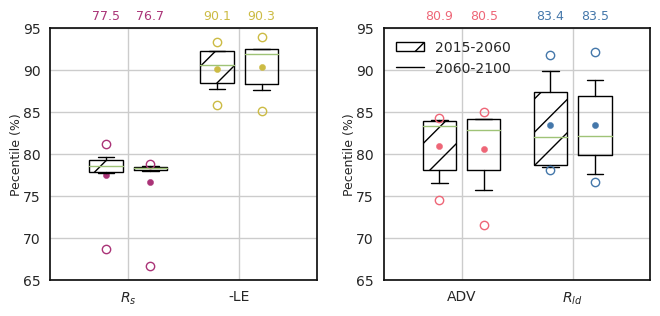

In [71]:
#fig= plt.figure(figsize=(5, 3))
fig,axs = plt.subplots(figsize=(8, 4),ncols=2,nrows=1)
#ax = plt.axes([0.2, 0.2, 0.65, 0.65])

all_data = []
for box_temp,l_c,pos in zip([[HW_ssr_all1_all,HW_ssr_all2_all],[HW_slfh_all1_all,np.array(HW_slfh_all2_all)],[HW_adv_all1_all,HW_adv_all2_all],[HW_strd_all1_all,np.array(HW_strd_all2_all)+0.03]],[colors_l[3],colors_l[5],colors_l[1],colors_l[4]],range(4)):
    ax=axs[pos//2]
    
    box_temp1 = (1-np.array(box_temp[0]))*100
    

    bp1 = ax.boxplot(box_temp1,widths=0.3, positions=[pos%2+1-0.2],whis = [5, 95],showfliers=True,flierprops = dict(marker='o', markerfacecolor=(0, 0, 0, 0),  markeredgecolor=l_c), patch_artist=True)
    ax.scatter([pos%2+1-0.2],np.nanmean(box_temp1),c=l_c,s=20)    
    # for element in ['whiskers','caps','medians','boxes','fliers']:
    #     for patch in bp[element] :
    #         plt.setp(patch, color=l_c)
    for box in bp1['boxes']:
        # change outline color
        #box.set(color='red', linewidth=2)
        # change fill color
        #box.set(facecolor = 'green' )
        # change hatch
        box.set_facecolor((0, 0, 0, 0))
        box.set(hatch = '/')    
    ax.text(pos%2+1-0.2,96,'%.1f'%((np.nanmean(box_temp1))),fontsize=9,c=l_c,ha='center')

    box_temp1 = (1-np.array(box_temp[1]))*100
    bp2 = ax.boxplot(box_temp1,widths=0.3, positions=[pos%2+1+0.2],whis = [5, 95],showfliers=True,flierprops = dict(marker='o', markerfacecolor=(0, 0, 0, 0),  markeredgecolor=l_c))
    ax.scatter([pos%2+1+0.2],np.nanmean(box_temp1),c=l_c,s=20)
    # for element in ['whiskers','caps','medians','boxes','fliers']:
    #     for patch in bp[element] :
    #         plt.setp(patch, color=l_c)

    ax.text(pos%2+1+0.2,96,'%.1f'%((np.nanmean(box_temp1))),fontsize=9,c=l_c,ha='center')
    
#ax.axhline(y = 0, color = 'grey', linestyle = '--')
#ax.axvline(x = 2.5, color = 'k', linestyle = '-')
for ax in axs:
    ax.set_ylabel('Pecentile (%)',labelpad=-0.01,fontsize=9) 
    for bnd in ['bottom','top','right','left']:
        ax.spines[bnd].set_color('k')
        ax.legend(fontsize=9)
        ax.set_ylim((65,95))
    
# ax.grid(b=False)
ax=axs[0]
ax.set_xticks([1,2])
ax.set_xticklabels(['$R_{s}$','-LE'],fontsize=10)
ax=axs[1]
ax.set_xticks([1,2])
ax.set_xticklabels(['ADV','$R_{ld}$'],fontsize=10)
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['2015-2060', '2060-2100'])

plt.subplots_adjust(wspace=0.25,bottom=0.25,left=0.15,right=0.9)
#fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_99th_connect6/cmip6_com_ALL1.jpg', dpi=300)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

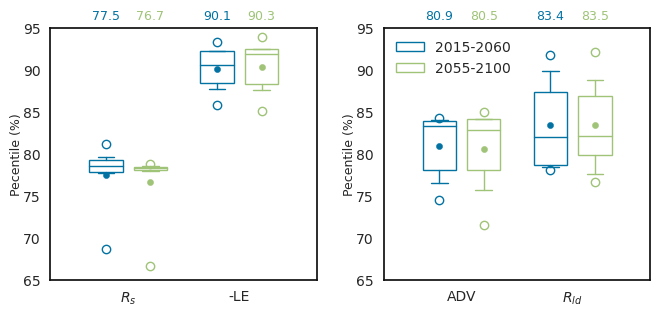

In [74]:
#fig= plt.figure(figsize=(5, 3))
fig,axs = plt.subplots(figsize=(8, 4),ncols=2,nrows=1)
#ax = plt.axes([0.2, 0.2, 0.65, 0.65])

all_data = []
for box_temp,l_c,pos in zip([[HW_ssr_all1_all,HW_ssr_all2_all],[HW_slfh_all1_all,np.array(HW_slfh_all2_all)],[HW_adv_all1_all,HW_adv_all2_all],[HW_strd_all1_all,np.array(HW_strd_all2_all)+0.03]],[colors_l[3],colors_l[5],colors_l[1],colors_l[4]],range(4)):
    
    ax=axs[pos//2]
    box_temp1 = (1-np.array(box_temp[0]))*100
    l_c=colors[0]
    

    bp1 = ax.boxplot(box_temp1,widths=0.3, positions=[pos%2+1-0.2],whis = [5, 95],showfliers=True,flierprops = dict(marker='o', markerfacecolor=(0, 0, 0, 0),  markeredgecolor=l_c), patch_artist=True)
    ax.scatter([pos%2+1-0.2],np.nanmean(box_temp1),c=l_c,s=20)    
    for element in ['whiskers','caps','medians','boxes','fliers']:
        for patch in bp1[element] :
            plt.setp(patch, color=l_c)
    for box in bp1['boxes']:
        # change outline color
        #box.set(color='red', linewidth=2)
        # change fill color
        #box.set(facecolor = 'green' )
        # change hatch
        box.set_facecolor((0, 0, 0, 0))
        #box.set(hatch = '/')    
    ax.text(pos%2+1-0.2,96,'%.1f'%((np.nanmean(box_temp1))),fontsize=9,c=l_c,ha='center')

    box_temp1 = (1-np.array(box_temp[1]))*100
    l_c=colors[1]
    bp2 = ax.boxplot(box_temp1,widths=0.3, positions=[pos%2+1+0.2],whis = [5, 95],showfliers=True,flierprops = dict(marker='o', markerfacecolor=(0, 0, 0, 0),  markeredgecolor=l_c), patch_artist=True)
    ax.scatter([pos%2+1+0.2],np.nanmean(box_temp1),c=l_c,s=20)
    for element in ['whiskers','caps','medians','boxes','fliers']:
        for patch in bp2[element] :
            plt.setp(patch, color=l_c)
    for box in bp2['boxes']:
        # change outline color
        #box.set(color='red', linewidth=2)
        # change fill color
        #box.set(facecolor = 'green' )
        # change hatch
        box.set_facecolor((0, 0, 0, 0))
        #box.set(hatch = '/')  
    ax.text(pos%2+1+0.2,96,'%.1f'%((np.nanmean(box_temp1))),fontsize=9,c=l_c,ha='center')
    
#ax.axhline(y = 0, color = 'grey', linestyle = '--')
#ax.axvline(x = 2.5, color = 'k', linestyle = '-')
for ax in axs:
    ax.set_ylabel('Pecentile (%)',labelpad=-0.01,fontsize=9) 
    for bnd in ['bottom','top','right','left']:
        ax.spines[bnd].set_color('k')
        ax.legend(fontsize=9)
        ax.set_ylim((65,95))
    ax.grid(False)
    
# ax.grid(b=False)
ax=axs[0]
ax.set_xticks([1,2])
ax.set_xticklabels(['$R_{s}$','-LE'],fontsize=10)
ax=axs[1]
ax.set_xticks([1,2])
ax.set_xticklabels(['ADV','$R_{ld}$'],fontsize=10)
ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['2015-2060', '2055-2100'])

plt.subplots_adjust(wspace=0.25,bottom=0.25,left=0.15,right=0.9)
fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_99th_connect6/cmip6_com_ALL1.jpg', dpi=300)

# slope data


In [10]:
for box_temp,pos in zip([[HW_ssr_all1_all,HW_ssr_all2_all],[HW_slfh_all1_all,np.array(HW_slfh_all2_all)],[HW_adv_all1_all,HW_adv_all2_all],[HW_strd_all1_all,np.array(HW_strd_all2_all)+0.03]],range(4)):
    box_temp1 = (1-np.array(box_temp[0]))*100
    print('2015',box_temp1)

    box_temp1 = (1-np.array(box_temp[1]))*100
    print('2055',box_temp1)

    print()

2015 [79.58414672 78.49787197 77.91235893 81.15687027 68.70119887 78.8778737
 77.72634747]
2055 [77.93981207 78.61622442 78.30191375 78.82211806 66.67392666 78.20742196
 78.26776386]

2015 [93.34457102 92.24814899 92.17963406 89.08007552 90.63348021 87.70020191
 85.81425756]
2055 [93.88573815 92.50434342 92.42153079 88.9956364  91.83696345 87.63966818
 85.10492756]

2015 [79.65306466 83.35274375 84.25733179 83.91930488 83.98160042 76.5375176
 74.47515098]
2055 [80.47358552 84.05044299 84.14747496 84.9921133  82.88018619 75.6872383
 71.48925552]

2015 [84.79197084 78.98412049 78.12680927 82.04201364 78.47899441 89.85842185
 91.78759463]
2055 [84.94998859 76.71049314 77.66206182 82.09688488 82.01925663 88.75808005
 92.12775012]



In [11]:
delta_ssr_po = []
delta_ssr_ne = []
delta_slhf_po = []
delta_slhf_ne = []
delta_SDcorr_po = []
delta_SDcorr_ne = []
delta_SDslope_po = []
delta_SDslope_ne = []

delta_ssr_po_fix = []
delta_ssr_ne_fix = []
delta_slhf_po_fix = []
delta_slhf_ne_fix = []

for i_model,modelname in enumerate(['CanESM5/','INM-CM4-8/','INM-CM5-0/','MPI-ESM1-2-LR/','MRI-ESM2-0/','CMCC-ESM2/','IPSL-CM6A-LR/']):
    per_ssr1 = (1-HW_ssr_all1_all[i_model])*100
    per_ssr2 = (1-HW_ssr_all2_all[i_model] )*100   
    per_slfh1 = (1-HW_slfh_all1_all[i_model])*100
    per_slfh2 = (1-HW_slfh_all2_all[i_model] )*100

    per_ssr_fix = 1-1/4
    per_slfh_fix = 1-1/10
    senarioname = 'ssp585'

    print(modelname)

    yearstart=2015
    yearend=2060
    yearrange = np.arange(yearstart,yearend+1)

    lon_unin = np.arange(-180,180,2.5)
    lat_unin = np.arange(-90,90,2.5)[::-1]
    LON_unin, LAT_unin = np.meshgrid(lon_unin, lat_unin)
    ##
    NCname = '/Net/Groups/BGI/scratch/yt/data/era5_daily_1x1/land_mask.nc'
    NCData = Dataset(NCname)
    land_mask = np.squeeze(NCData.variables['lsm'][:])
    NCData.close()
    NCname = r'/Net/Groups/BGI/scratch/yt/data/era5_daily_1x1/t2m_1979_2020_dailymax_1x1_delFeb29.nc'
    NCData = Dataset(NCname)
    lon_era5 = NCData.variables['lon'][:]
    lat_era5 = NCData.variables['lat'][:]
    LON_era5, LAT_era5 = np.meshgrid(lon_era5, lat_era5)
    NCData.close()
    land_mask = np.concatenate((land_mask[:,180:] ,land_mask[:,:180]),axis=1 )
    lon_era5 = np.concatenate((lon_era5[180:]-360 ,lon_era5[:180]) )
    LON_era5 = np.concatenate((LON_era5[:,180:]-360 ,LON_era5[:,:180]),axis=1 )
    ##
    LAT_unin1 = copy.deepcopy(LAT_unin)
    LON_unin1 = copy.deepcopy(LON_unin)
    LAT_unin1[LAT_unin1>np.nanmax(lat_era5)] = np.nanmax(lat_era5)
    LAT_unin1[LAT_unin1<np.nanmin(lat_era5)] = np.nanmin(lat_era5)
    LON_unin1[LON_unin1>np.nanmax(lon_era5)] = np.nanmax(lon_era5)
    LON_unin1[LON_unin1<np.nanmin(lon_era5)] = np.nanmin(lon_era5)

    my_interpolating_function = RegularGridInterpolator((lat_era5,lon_era5), land_mask)
    land_mask =  my_interpolating_function((LAT_unin1.ravel(), LON_unin1.ravel())).reshape((len(LAT_unin1[:,0]),len(LON_unin1[0])))

    #%% file info
    filelist_cmip6 = os.listdir(r'/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname)
    filelist_cmip6 = np.array([i for i in filelist_cmip6 if i[:6]=='tasmax'])
    temp = r'/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+filelist_cmip6[0]
    grid_label = temp[temp.find('_g')+1:temp.find('_g')+1+temp[temp.find('_g')+1:].find('_')]
    filelist_cmip6 = np.array([i for i in filelist_cmip6 if i[-31-len(grid_label)-len(senarioname):-31-len(grid_label)]==senarioname])
    filelist_cmip6_2 = np.array([int(i[-11:-7]) for i in filelist_cmip6])
    filelist_cmip6_1 = np.array([int(i[-20:-16]) for i in filelist_cmip6])
    filelist_cmip6 = np.array(filelist_cmip6)[~((filelist_cmip6_2<yearstart)|(filelist_cmip6_1>yearend))]   
    filelist_cmip6 = np.array(filelist_cmip6)[np.argsort(np.array([int(i[-20:-16]) for i in filelist_cmip6]))]


    #%%%%%%%%%%%%%%%%%%%%%%% spatial info
    filename = r'/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+filelist_cmip6[0]
    NCData = Dataset( filename)
    lon_cmip6 = NCData.variables['lon'][:]
    lat_cmip6 = NCData.variables['lat'][:][::-1]
    LON_cmip6, LAT_cmip6 = np.meshgrid(lon_cmip6, lat_cmip6)
    print(lon_cmip6[:10])
    print(lat_cmip6[:10])
    temp = int(len(lon_cmip6)*0.5)
    lon_cmip6 = np.concatenate((lon_cmip6[temp:]-360 ,lon_cmip6[:temp]) )
    LON_cmip6 = np.concatenate((LON_cmip6[:,temp:]-360 ,LON_cmip6[:,:temp]),axis=1 )
    LAT_unin2 = copy.deepcopy(LAT_unin)
    LON_unin2 = copy.deepcopy(LON_unin)
    LAT_unin2[LAT_unin2>np.nanmax(lat_cmip6)] = np.nanmax(lat_cmip6)
    LAT_unin2[LAT_unin2<np.nanmin(lat_cmip6)] = np.nanmin(lat_cmip6)
    LON_unin2[LON_unin2>np.nanmax(lon_cmip6)] = np.nanmax(lon_cmip6)
    LON_unin2[LON_unin2<np.nanmin(lon_cmip6)] = np.nanmin(lon_cmip6)

    #%%%%%%%%%%%%%%%%%%%%%%% temporal info
    ######time
    year_cmip6_all = []
    mon_cmip6_all = []
    day_cmip6_all = []
    for filename in filelist_cmip6:
        
        filename = r'/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+filename
        NCData = Dataset( filename)
        # lon_cmip6 = NCData.variables['lon'][:]
        # lat_cmip6 = NCData.variables['lat'][:][::-1]
        # LON_cmip6, LAT_cmip6 = np.meshgrid(lon_cmip6, lat_cmip6)
        time = NCData.variables['time']
        dates = list(num2date(time[:], time.units, time.calendar))
        year = np.array([date.year for date in dates])
        year_where = np.where(np.in1d(year,yearrange))[0]
        if len(year_where)==0:
            continue
        print (filename)
        year_temp = np.array([date.year for date in dates])[year_where ]
        mon_temp = np.array([date.month for date in dates])[year_where ]
        day_temp = np.array([date.day for date in dates])[year_where ]

        tmax_temp = NCData.variables['tasmax'][year_where][:,::-1,:]

        year_cmip6_all.extend(year_temp)
        mon_cmip6_all.extend(mon_temp)
        day_cmip6_all.extend(day_temp)
    md_cmip6_all = 100*np.array(mon_cmip6_all)+np.array(day_cmip6_all)
    year_cmip6_all = np.squeeze(np.array(year_cmip6_all)[md_cmip6_all!=229])
    mon_cmip6_all = np.squeeze(np.array(mon_cmip6_all)[md_cmip6_all!=229])
    day_cmip6_all = np.squeeze(np.array(day_cmip6_all)[md_cmip6_all!=229])

    md_cmip6_all = np.squeeze(md_cmip6_all )
    print(len(md_cmip6_all))
    #%%
    ssr1 = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'ssr'+'_ano_'+str(yearstart)+'_'+str(yearend)+'_dailymean_2.5x2.5_del29Feb.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)
    slhf1 = -np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'slhf'+'_ano_'+str(yearstart)+'_'+str(yearend)+'_dailymean_2.5x2.5_del29Feb.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)

    ssr1_sum = np.zeros((ssr1.shape[1],ssr1.shape[2]))
    ssr1_sum[lat_unin>23.5,:] = np.nanpercentile(ssr1[np.in1d(mon_cmip6_all,[6,7,8])],per_ssr1,axis=0)[lat_unin>23.5,:]
    ssr1_sum[np.where(lat_unin<-23.5)[0],:] = np.nanpercentile(ssr1[np.in1d(mon_cmip6_all,[12,1,2])],per_ssr1,axis=0)[lat_unin<-23.5,:]
    ssr1_sum[np.where((lat_unin>-23.5)&(lat_unin<23.5))[0],:] = np.nanpercentile(ssr1,per_ssr1,axis=0)[(lat_unin>-23.5)&(lat_unin<23.5)]

    slhf1_sum = np.zeros((slhf1.shape[1],slhf1.shape[2]))
    slhf1_sum[lat_unin>23.5,:] = np.nanpercentile(slhf1[np.in1d(mon_cmip6_all,[6,7,8])],per_slfh1,axis=0)[lat_unin>23.5,:]
    slhf1_sum[np.where(lat_unin<-23.5)[0],:] = np.nanpercentile(slhf1[np.in1d(mon_cmip6_all,[12,1,2])],per_slfh1,axis=0)[lat_unin<-23.5,:]
    slhf1_sum[np.where((lat_unin>-23.5)&(lat_unin<23.5))[0],:] = np.nanpercentile(slhf1,per_slfh1,axis=0)[(lat_unin>-23.5)&(lat_unin<23.5)]

    ssr1_sum_fix = np.zeros((ssr1.shape[1],ssr1.shape[2]))
    ssr1_sum_fix[lat_unin>23.5,:] = np.nanpercentile(ssr1[np.in1d(mon_cmip6_all,[6,7,8])],per_ssr_fix,axis=0)[lat_unin>23.5,:]
    ssr1_sum_fix[np.where(lat_unin<-23.5)[0],:] = np.nanpercentile(ssr1[np.in1d(mon_cmip6_all,[12,1,2])],per_ssr_fix,axis=0)[lat_unin<-23.5,:]
    ssr1_sum_fix[np.where((lat_unin>-23.5)&(lat_unin<23.5))[0],:] = np.nanpercentile(ssr1,per_ssr_fix,axis=0)[(lat_unin>-23.5)&(lat_unin<23.5)]

    slhf1_sum_fix = np.zeros((slhf1.shape[1],slhf1.shape[2]))
    slhf1_sum_fix[lat_unin>23.5,:] = np.nanpercentile(slhf1[np.in1d(mon_cmip6_all,[6,7,8])],per_slfh_fix,axis=0)[lat_unin>23.5,:]
    slhf1_sum_fix[np.where(lat_unin<-23.5)[0],:] = np.nanpercentile(slhf1[np.in1d(mon_cmip6_all,[12,1,2])],per_slfh_fix,axis=0)[lat_unin<-23.5,:]
    slhf1_sum_fix[np.where((lat_unin>-23.5)&(lat_unin<23.5))[0],:] = np.nanpercentile(slhf1,per_slfh_fix,axis=0)[(lat_unin>-23.5)&(lat_unin<23.5)]


    SD_corr1 = np.load( r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'Corr_SSR_LE_'+str(yearstart)+'_'+str(yearend) ,allow_pickle=True)
    SD_corr1 = np.array([np.abs(i) for i in SD_corr1.ravel()]).reshape((SD_corr1.shape[0],SD_corr1.shape[1]))
    SD_slope1 = np.load( r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'slope_SSR_LE_'+str(yearstart)+'_'+str(yearend) ,allow_pickle=True)

    yearstart=2055
    yearend=2100
    yearrange = np.arange(yearstart,yearend+1)

    lon_unin = np.arange(-180,180,2.5)
    lat_unin = np.arange(-90,90,2.5)[::-1]
    LON_unin, LAT_unin = np.meshgrid(lon_unin, lat_unin)
    ##
    NCname = '/Net/Groups/BGI/scratch/yt/data/era5_daily_1x1/land_mask.nc'
    NCData = Dataset(NCname)
    land_mask = np.squeeze(NCData.variables['lsm'][:])
    NCData.close()
    NCname = r'/Net/Groups/BGI/scratch/yt/data/era5_daily_1x1/t2m_1979_2020_dailymax_1x1_delFeb29.nc'
    NCData = Dataset(NCname)
    lon_era5 = NCData.variables['lon'][:]
    lat_era5 = NCData.variables['lat'][:]
    LON_era5, LAT_era5 = np.meshgrid(lon_era5, lat_era5)
    NCData.close()
    land_mask = np.concatenate((land_mask[:,180:] ,land_mask[:,:180]),axis=1 )
    lon_era5 = np.concatenate((lon_era5[180:]-360 ,lon_era5[:180]) )
    LON_era5 = np.concatenate((LON_era5[:,180:]-360 ,LON_era5[:,:180]),axis=1 )
    ##
    LAT_unin1 = copy.deepcopy(LAT_unin)
    LON_unin1 = copy.deepcopy(LON_unin)
    LAT_unin1[LAT_unin1>np.nanmax(lat_era5)] = np.nanmax(lat_era5)
    LAT_unin1[LAT_unin1<np.nanmin(lat_era5)] = np.nanmin(lat_era5)
    LON_unin1[LON_unin1>np.nanmax(lon_era5)] = np.nanmax(lon_era5)
    LON_unin1[LON_unin1<np.nanmin(lon_era5)] = np.nanmin(lon_era5)

    my_interpolating_function = RegularGridInterpolator((lat_era5,lon_era5), land_mask)
    land_mask =  my_interpolating_function((LAT_unin1.ravel(), LON_unin1.ravel())).reshape((len(LAT_unin1[:,0]),len(LON_unin1[0])))

    #%% file info
    filelist_cmip6 = os.listdir(r'/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname)
    filelist_cmip6 = np.array([i for i in filelist_cmip6 if i[:6]=='tasmax'])
    temp = r'/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+filelist_cmip6[0]
    grid_label = temp[temp.find('_g')+1:temp.find('_g')+1+temp[temp.find('_g')+1:].find('_')]
    filelist_cmip6 = np.array([i for i in filelist_cmip6 if i[-31-len(grid_label)-len(senarioname):-31-len(grid_label)]==senarioname])
    filelist_cmip6_2 = np.array([int(i[-11:-7]) for i in filelist_cmip6])
    filelist_cmip6_1 = np.array([int(i[-20:-16]) for i in filelist_cmip6])
    filelist_cmip6 = np.array(filelist_cmip6)[~((filelist_cmip6_2<yearstart)|(filelist_cmip6_1>yearend))]   
    filelist_cmip6 = np.array(filelist_cmip6)[np.argsort(np.array([int(i[-20:-16]) for i in filelist_cmip6]))]


    #%%%%%%%%%%%%%%%%%%%%%%% spatial info
    filename = r'/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+filelist_cmip6[0]
    NCData = Dataset( filename)
    lon_cmip6 = NCData.variables['lon'][:]
    lat_cmip6 = NCData.variables['lat'][:][::-1]
    LON_cmip6, LAT_cmip6 = np.meshgrid(lon_cmip6, lat_cmip6)
    print(lon_cmip6[:10])
    print(lat_cmip6[:10])
    temp = int(len(lon_cmip6)*0.5)
    lon_cmip6 = np.concatenate((lon_cmip6[temp:]-360 ,lon_cmip6[:temp]) )
    LON_cmip6 = np.concatenate((LON_cmip6[:,temp:]-360 ,LON_cmip6[:,:temp]),axis=1 )
    LAT_unin2 = copy.deepcopy(LAT_unin)
    LON_unin2 = copy.deepcopy(LON_unin)
    LAT_unin2[LAT_unin2>np.nanmax(lat_cmip6)] = np.nanmax(lat_cmip6)
    LAT_unin2[LAT_unin2<np.nanmin(lat_cmip6)] = np.nanmin(lat_cmip6)
    LON_unin2[LON_unin2>np.nanmax(lon_cmip6)] = np.nanmax(lon_cmip6)
    LON_unin2[LON_unin2<np.nanmin(lon_cmip6)] = np.nanmin(lon_cmip6)

    #%%%%%%%%%%%%%%%%%%%%%%% temporal info
    ######time
    year_cmip6_all = []
    mon_cmip6_all = []
    day_cmip6_all = []
    for filename in filelist_cmip6:
        
        filename = r'/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+filename
        NCData = Dataset( filename)
        # lon_cmip6 = NCData.variables['lon'][:]
        # lat_cmip6 = NCData.variables['lat'][:][::-1]
        # LON_cmip6, LAT_cmip6 = np.meshgrid(lon_cmip6, lat_cmip6)
        time = NCData.variables['time']
        dates = list(num2date(time[:], time.units, time.calendar))
        year = np.array([date.year for date in dates])
        year_where = np.where(np.in1d(year,yearrange))[0]
        if len(year_where)==0:
            continue
        print (filename)
        year_temp = np.array([date.year for date in dates])[year_where ]
        mon_temp = np.array([date.month for date in dates])[year_where ]
        day_temp = np.array([date.day for date in dates])[year_where ]

        tmax_temp = NCData.variables['tasmax'][year_where][:,::-1,:]

        year_cmip6_all.extend(year_temp)
        mon_cmip6_all.extend(mon_temp)
        day_cmip6_all.extend(day_temp)
    md_cmip6_all = 100*np.array(mon_cmip6_all)+np.array(day_cmip6_all)
    year_cmip6_all = np.squeeze(np.array(year_cmip6_all)[md_cmip6_all!=229])
    mon_cmip6_all = np.squeeze(np.array(mon_cmip6_all)[md_cmip6_all!=229])
    day_cmip6_all = np.squeeze(np.array(day_cmip6_all)[md_cmip6_all!=229])

    md_cmip6_all = np.squeeze(md_cmip6_all )
    print(len(md_cmip6_all))
    #%%
    ssr2 = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'ssr'+'_ano_'+str(yearstart)+'_'+str(yearend)+'_dailymean_2.5x2.5_del29Feb.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)
    slhf2 = -np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'slhf'+'_ano_'+str(yearstart)+'_'+str(yearend)+'_dailymean_2.5x2.5_del29Feb.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)

    ssr2_sum = np.zeros((ssr2.shape[1],ssr2.shape[2]))
    ssr2_sum[lat_unin>23.5,:] = np.nanpercentile(ssr2[np.in1d(mon_cmip6_all,[6,7,8])],per_ssr2,axis=0)[lat_unin>23.5,:]
    ssr2_sum[np.where(lat_unin<-23.5)[0],:] = np.nanpercentile(ssr2[np.in1d(mon_cmip6_all,[12,1,2])],per_ssr2,axis=0)[lat_unin<-23.5,:]
    ssr2_sum[np.where((lat_unin>-23.5)&(lat_unin<23.5))[0],:] = np.nanpercentile(ssr2,per_ssr2,axis=0)[(lat_unin>-23.5)&(lat_unin<23.5)]

    slhf2_sum = np.zeros((slhf2.shape[1],slhf2.shape[2]))
    slhf2_sum[lat_unin>23.5,:] = np.nanpercentile(slhf2[np.in1d(mon_cmip6_all,[6,7,8])],per_slfh2,axis=0)[lat_unin>23.5,:]
    slhf2_sum[np.where(lat_unin<-23.5)[0],:] = np.nanpercentile(slhf2[np.in1d(mon_cmip6_all,[12,1,2])],per_slfh2,axis=0)[lat_unin<-23.5,:]
    slhf2_sum[np.where((lat_unin>-23.5)&(lat_unin<23.5))[0],:] = np.nanpercentile(slhf2,per_slfh2,axis=0)[(lat_unin>-23.5)&(lat_unin<23.5)]

    ssr2_sum_fix = np.zeros((ssr2.shape[1],ssr2.shape[2]))
    ssr2_sum_fix[lat_unin>23.5,:] = np.nanpercentile(ssr2[np.in1d(mon_cmip6_all,[6,7,8])],per_ssr_fix,axis=0)[lat_unin>23.5,:]
    ssr2_sum_fix[np.where(lat_unin<-23.5)[0],:] = np.nanpercentile(ssr2[np.in1d(mon_cmip6_all,[12,1,2])],per_ssr_fix,axis=0)[lat_unin<-23.5,:]
    ssr2_sum_fix[np.where((lat_unin>-23.5)&(lat_unin<23.5))[0],:] = np.nanpercentile(ssr2,per_ssr_fix,axis=0)[(lat_unin>-23.5)&(lat_unin<23.5)]

    slhf2_sum_fix = np.zeros((slhf2.shape[1],slhf2.shape[2]))
    slhf2_sum_fix[lat_unin>23.5,:] = np.nanpercentile(slhf2[np.in1d(mon_cmip6_all,[6,7,8])],per_slfh_fix,axis=0)[lat_unin>23.5,:]
    slhf2_sum_fix[np.where(lat_unin<-23.5)[0],:] = np.nanpercentile(slhf2[np.in1d(mon_cmip6_all,[12,1,2])],per_slfh_fix,axis=0)[lat_unin<-23.5,:]
    slhf2_sum_fix[np.where((lat_unin>-23.5)&(lat_unin<23.5))[0],:] = np.nanpercentile(slhf2,per_slfh_fix,axis=0)[(lat_unin>-23.5)&(lat_unin<23.5)]

    SD_corr2 = np.load( r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'Corr_SSR_LE_'+str(yearstart)+'_'+str(yearend) ,allow_pickle=True)
    SD_corr2 = np.array([np.abs(i) for i in SD_corr2.ravel()]).reshape((SD_corr2.shape[0],SD_corr2.shape[1]))
    SD_slope2 = np.load( r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'slope_SSR_LE_'+str(yearstart)+'_'+str(yearend) ,allow_pickle=True)

    vername = '_235_'+str(2015)+'_'+str(2060)
    land_map1 = np.load(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'label_map_o'+vername,allow_pickle=True)[1]
    vername = '_235_'+str(2055)+'_'+str(2100)
    land_map2 = np.load(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'label_map_o'+vername,allow_pickle=True)[1]
    land_map = land_map2-land_map1

    delta_ssr = ssr2_sum-ssr1_sum
    delta_slhf = slhf2_sum-slhf1_sum
    delta_SDcorr = -(SD_corr2-SD_corr1)
    delta_SDslope = -(SD_slope2-SD_slope1)
    delta_ssr_fix = ssr2_sum_fix-ssr1_sum_fix
    delta_slhf_fix = slhf2_sum_fix-slhf1_sum_fix


    delta_ssr_po.append(np.nanmean(delta_ssr[land_map>0]))
    delta_ssr_ne.append(np.nanmean(delta_ssr[land_map<0]))
    delta_slhf_po.append(np.nanmean(delta_slhf[land_map>0]))
    delta_slhf_ne.append(np.nanmean(delta_slhf[land_map<0]))
    delta_SDcorr_po.append(np.nanmean(delta_SDcorr[land_map>0]))
    delta_SDcorr_ne.append(np.nanmean(delta_SDcorr[land_map<0]))
    delta_SDslope_po.append(np.nanmean(delta_SDslope[land_map>0]))
    delta_SDslope_ne.append(np.nanmean(delta_SDslope[land_map<0]))   


    delta_ssr_po_fix.append(np.nanmean(delta_ssr_fix[land_map>0]))
    delta_ssr_ne_fix.append(np.nanmean(delta_ssr_fix[land_map<0]))
    delta_slhf_po_fix.append(np.nanmean(delta_slhf_fix[land_map>0]))
    delta_slhf_ne_fix.append(np.nanmean(delta_slhf_fix[land_map<0]))
    # ssr_scatter1 = []
    # for i in ssr1:
    #     ssr_scatter1.append(np.nanmean(i[(lat_unin>-23.5)&(lat_unin<23.5)][land_map[(lat_unin>-23.5)&(lat_unin<23.5)]>0]))
    # slhf_scatter1 = []
    # for i in slhf1:
    #     slhf_scatter1.append(np.nanmean(i[(lat_unin>-23.5)&(lat_unin<23.5)][land_map[(lat_unin>-23.5)&(lat_unin<23.5)]>0]))
    # ssr_scatter2 = []
    # for i in ssr2:
    #     ssr_scatter2.append(np.nanmean(i[(lat_unin>-23.5)&(lat_unin<23.5)][land_map[(lat_unin>-23.5)&(lat_unin<23.5)]>0]))
    # slhf_scatter2 = []
    # for i in slhf2:
    #     slhf_scatter2.append(np.nanmean(i[(lat_unin>-23.5)&(lat_unin<23.5)][land_map[(lat_unin>-23.5)&(lat_unin<23.5)]>0]))
    # results = pd.DataFrame({'SSR_1':np.array(ssr_scatter1).squeeze()[np.in1d(mon_cmip6_all,[6,7,8])],
    #                         'slhf_1': np.array(slhf_scatter1).squeeze()[np.in1d(mon_cmip6_all,[6,7,8])],
    #                         'SSR_2':np.array(ssr_scatter2).squeeze()[np.in1d(mon_cmip6_all,[6,7,8])],
    #                         'slhf_2': np.array(slhf_scatter2).squeeze()[np.in1d(mon_cmip6_all,[6,7,8])],
    #                         },)

    # fig, ax = plt.subplots(figsize=(4,4))

    # slope1, intercept, r_value1, p_value, std_err = scipy.stats.linregress(x=results['SSR_1'],y=results['slhf_1'])
    # slope2, intercept, r_value2, p_value, std_err = scipy.stats.linregress(x=results['SSR_2'],y=results['slhf_2'])
    # sns.regplot(data=results, x='SSR_1', y='slhf_1',scatter_kws = { "alpha": 0.1,"s":5},line_kws={ "color": 'blue'})
    # sns.regplot(data=results, x='SSR_2', y='slhf_2',scatter_kws = { "alpha": 0.1,"s":5},line_kws={ "color": 'green'})
    # sns.kdeplot(data=results, x='SSR_1', y='slhf_1',levels=[0.5],color='blue', label='2015-2060 slope=%.2f'%slope1)
    # sns.kdeplot(data=results, x='SSR_2', y='slhf_2',levels=[0.5],color='green', label='2055-2100 slope=%.2f'%slope2)
    # plt.legend()
    # plt.xlabel('Rs (K)')
    # plt.ylabel('-LH (K)')
    # plt.tight_layout()
    # fig.savefig('kde_SD_LH'+modelname[:-1]+'.jpg')


CanESM5/
[ 0.      2.8125  5.625   8.4375 11.25   14.0625 16.875  19.6875 22.5
 25.3125]
[87.86379884 85.09652699 82.31291295 79.52560657 76.73689968 73.94751515
 71.15775201 68.36775611 65.57760701 62.7873518 ]
/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/CanESM5/tasmax_day_CanESM5_ssp585_r1i1p1f1_gn_20150101-21001231.nc
16790
[ 0.      2.8125  5.625   8.4375 11.25   14.0625 16.875  19.6875 22.5
 25.3125]
[87.86379884 85.09652699 82.31291295 79.52560657 76.73689968 73.94751515
 71.15775201 68.36775611 65.57760701 62.7873518 ]
/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/CanESM5/tasmax_day_CanESM5_ssp585_r1i1p1f1_gn_20150101-21001231.nc
16790
INM-CM4-8/
[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
[89.25 87.75 86.25 84.75 83.25 81.75 80.25 78.75 77.25 75.75]
/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/INM-CM4-8/tasmax_day_INM-CM4-8_ssp585_r1i1p1f1_gr1_20150101-20641231.nc
16790
[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
[89.25 87.75 86.25 84.75 83.25 81.75 80.25 78.75 77.25

/User/homes/ytian/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


[ 0.    1.25  2.5   3.75  5.    6.25  7.5   8.75 10.   11.25]
[90.         89.05759162 88.11518325 87.17277487 86.23036649 85.28795812
 84.34554974 83.40314136 82.46073298 81.51832461]
/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/CMCC-ESM2/tasmax_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_20400101-20641231.nc
/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/CMCC-ESM2/tasmax_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_20650101-20891231.nc
/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/CMCC-ESM2/tasmax_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_20900101-21001231.nc
16790
IPSL-CM6A-LR/
[ 0.   2.5  5.   7.5 10.  12.5 15.  17.5 20.  22.5]
[90.      88.73239 87.46479 86.19718 84.92958 83.66197 82.39436 81.12676
 79.85915 78.59155]
/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/IPSL-CM6A-LR/tasmax_day_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_20150101-21001231.nc
16802
[ 0.   2.5  5.   7.5 10.  12.5 15.  17.5 20.  22.5]
[90.      88.73239 87.46479 86.19718 84.92958 83.66197 82.39436 81.12676
 79.85915 78.59155]
/Net/Grou

In [12]:
ssr_scatter1 = []
for i in ssr1:
    ssr_scatter1.append(np.nanmean(i[(lat_unin>-23.5)&(lat_unin<23.5)][land_map[(lat_unin>-23.5)&(lat_unin<23.5)]>0]))
slhf_scatter1 = []
for i in slhf1:
    slhf_scatter1.append(np.nanmean(i[(lat_unin>-23.5)&(lat_unin<23.5)][land_map[(lat_unin>-23.5)&(lat_unin<23.5)]>0]))
ssr_scatter2 = []
for i in ssr2:
    ssr_scatter2.append(np.nanmean(i[(lat_unin>-23.5)&(lat_unin<23.5)][land_map[(lat_unin>-23.5)&(lat_unin<23.5)]>0]))
slhf_scatter2 = []
for i in slhf2:
    slhf_scatter2.append(np.nanmean(i[(lat_unin>-23.5)&(lat_unin<23.5)][land_map[(lat_unin>-23.5)&(lat_unin<23.5)]>0]))


In [16]:
delta_strd_po = []
delta_strd_ne = []
delta_adv_po = []
delta_adv_ne = []

delta_ADVcorr_po = []
delta_ADVcorr_ne = []
delta_ADVslope_po = []
delta_ADVslope_ne = []

delta_strd_po_fix = []
delta_strd_ne_fix = []
delta_adv_po_fix = []
delta_adv_ne_fix = []
for i_model,modelname in enumerate(['CanESM5/','INM-CM4-8/','INM-CM5-0/','MPI-ESM1-2-LR/','MRI-ESM2-0/','CMCC-ESM2/','IPSL-CM6A-LR/']):
    per_strd1 = (1-HW_strd_all1_all[i_model])*100
    per_strd2 = (1-HW_strd_all2_all[i_model]    )*100
    per_adv1 = (1-HW_adv_all1_all[i_model])*100
    per_adv2 = (1-HW_adv_all2_all[i_model] )*100

    per_strd_fix = 1-1/6
    per_strd_fix = 1-1/6  
    per_adv_fix = 1-1/5.5
    per_adv_fix = 1-1/5.5
    senarioname = 'ssp585'

    print(modelname)

    yearstart=2015
    yearend=2060
    yearrange = np.arange(yearstart,yearend+1)

    lon_unin = np.arange(-180,180,2.5)
    lat_unin = np.arange(-90,90,2.5)[::-1]
    LON_unin, LAT_unin = np.meshgrid(lon_unin, lat_unin)
    ##
    NCname = '/Net/Groups/BGI/scratch/yt/data/era5_daily_1x1/land_mask.nc'
    NCData = Dataset(NCname)
    land_mask = np.squeeze(NCData.variables['lsm'][:])
    NCData.close()
    NCname = r'/Net/Groups/BGI/scratch/yt/data/era5_daily_1x1/t2m_1979_2020_dailymax_1x1_delFeb29.nc'
    NCData = Dataset(NCname)
    lon_era5 = NCData.variables['lon'][:]
    lat_era5 = NCData.variables['lat'][:]
    LON_era5, LAT_era5 = np.meshgrid(lon_era5, lat_era5)
    NCData.close()
    land_mask = np.concatenate((land_mask[:,180:] ,land_mask[:,:180]),axis=1 )
    lon_era5 = np.concatenate((lon_era5[180:]-360 ,lon_era5[:180]) )
    LON_era5 = np.concatenate((LON_era5[:,180:]-360 ,LON_era5[:,:180]),axis=1 )
    ##
    LAT_unin1 = copy.deepcopy(LAT_unin)
    LON_unin1 = copy.deepcopy(LON_unin)
    LAT_unin1[LAT_unin1>np.nanmax(lat_era5)] = np.nanmax(lat_era5)
    LAT_unin1[LAT_unin1<np.nanmin(lat_era5)] = np.nanmin(lat_era5)
    LON_unin1[LON_unin1>np.nanmax(lon_era5)] = np.nanmax(lon_era5)
    LON_unin1[LON_unin1<np.nanmin(lon_era5)] = np.nanmin(lon_era5)

    my_interpolating_function = RegularGridInterpolator((lat_era5,lon_era5), land_mask)
    land_mask =  my_interpolating_function((LAT_unin1.ravel(), LON_unin1.ravel())).reshape((len(LAT_unin1[:,0]),len(LON_unin1[0])))

    #%% file info
    filelist_cmip6 = os.listdir(r'/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname)
    filelist_cmip6 = np.array([i for i in filelist_cmip6 if i[:6]=='tasmax'])
    temp = r'/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+filelist_cmip6[0]
    grid_label = temp[temp.find('_g')+1:temp.find('_g')+1+temp[temp.find('_g')+1:].find('_')]
    filelist_cmip6 = np.array([i for i in filelist_cmip6 if i[-31-len(grid_label)-len(senarioname):-31-len(grid_label)]==senarioname])
    filelist_cmip6_2 = np.array([int(i[-11:-7]) for i in filelist_cmip6])
    filelist_cmip6_1 = np.array([int(i[-20:-16]) for i in filelist_cmip6])
    filelist_cmip6 = np.array(filelist_cmip6)[~((filelist_cmip6_2<yearstart)|(filelist_cmip6_1>yearend))]   
    filelist_cmip6 = np.array(filelist_cmip6)[np.argsort(np.array([int(i[-20:-16]) for i in filelist_cmip6]))]


    #%%%%%%%%%%%%%%%%%%%%%%% spatial info
    filename = r'/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+filelist_cmip6[0]
    NCData = Dataset( filename)
    lon_cmip6 = NCData.variables['lon'][:]
    lat_cmip6 = NCData.variables['lat'][:][::-1]
    LON_cmip6, LAT_cmip6 = np.meshgrid(lon_cmip6, lat_cmip6)
    print(lon_cmip6[:10])
    print(lat_cmip6[:10])
    temp = int(len(lon_cmip6)*0.5)
    lon_cmip6 = np.concatenate((lon_cmip6[temp:]-360 ,lon_cmip6[:temp]) )
    LON_cmip6 = np.concatenate((LON_cmip6[:,temp:]-360 ,LON_cmip6[:,:temp]),axis=1 )
    LAT_unin2 = copy.deepcopy(LAT_unin)
    LON_unin2 = copy.deepcopy(LON_unin)
    LAT_unin2[LAT_unin2>np.nanmax(lat_cmip6)] = np.nanmax(lat_cmip6)
    LAT_unin2[LAT_unin2<np.nanmin(lat_cmip6)] = np.nanmin(lat_cmip6)
    LON_unin2[LON_unin2>np.nanmax(lon_cmip6)] = np.nanmax(lon_cmip6)
    LON_unin2[LON_unin2<np.nanmin(lon_cmip6)] = np.nanmin(lon_cmip6)

    #%%%%%%%%%%%%%%%%%%%%%%% temporal info
    ######time
    year_cmip6_all = []
    mon_cmip6_all = []
    day_cmip6_all = []
    for filename in filelist_cmip6:
        
        filename = r'/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+filename
        NCData = Dataset( filename)
        # lon_cmip6 = NCData.variables['lon'][:]
        # lat_cmip6 = NCData.variables['lat'][:][::-1]
        # LON_cmip6, LAT_cmip6 = np.meshgrid(lon_cmip6, lat_cmip6)
        time = NCData.variables['time']
        dates = list(num2date(time[:], time.units, time.calendar))
        year = np.array([date.year for date in dates])
        year_where = np.where(np.in1d(year,yearrange))[0]
        if len(year_where)==0:
            continue
        print (filename)
        year_temp = np.array([date.year for date in dates])[year_where ]
        mon_temp = np.array([date.month for date in dates])[year_where ]
        day_temp = np.array([date.day for date in dates])[year_where ]

        tmax_temp = NCData.variables['tasmax'][year_where][:,::-1,:]

        year_cmip6_all.extend(year_temp)
        mon_cmip6_all.extend(mon_temp)
        day_cmip6_all.extend(day_temp)
    md_cmip6_all = 100*np.array(mon_cmip6_all)+np.array(day_cmip6_all)
    year_cmip6_all = np.squeeze(np.array(year_cmip6_all)[md_cmip6_all!=229])
    mon_cmip6_all = np.squeeze(np.array(mon_cmip6_all)[md_cmip6_all!=229])
    day_cmip6_all = np.squeeze(np.array(day_cmip6_all)[md_cmip6_all!=229])

    md_cmip6_all = np.squeeze(md_cmip6_all )
    print(len(md_cmip6_all))
    #%%
    strd1 = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'strd'+'_ano_'+str(yearstart)+'_'+str(yearend)+'_dailymean_2.5x2.5_del29Feb.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)
    adv1 = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'adv'+'_ano_'+str(yearstart)+'_'+str(yearend)+'_dailymean_2.5x2.5_del29Feb.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)

    strd1_sum = np.zeros((strd1.shape[1],strd1.shape[2]))
    strd1_sum[lat_unin>23.5,:] = np.nanpercentile(strd1[np.in1d(mon_cmip6_all,[6,7,8])],per_strd1,axis=0)[lat_unin>23.5,:]
    strd1_sum[np.where(lat_unin<-23.5)[0],:] = np.nanpercentile(strd1[np.in1d(mon_cmip6_all,[12,1,2])],per_strd1,axis=0)[lat_unin<-23.5,:]
    strd1_sum[np.where((lat_unin>-23.5)&(lat_unin<23.5))[0],:] = np.nanpercentile(strd1,per_strd1,axis=0)[(lat_unin>-23.5)&(lat_unin<23.5)]

    adv1_sum = np.zeros((adv1.shape[1],adv1.shape[2]))
    adv1_sum[lat_unin>23.5,:] = np.nanpercentile(adv1[np.in1d(mon_cmip6_all,[6,7,8])],per_adv1,axis=0)[lat_unin>23.5,:]
    adv1_sum[np.where(lat_unin<-23.5)[0],:] = np.nanpercentile(adv1[np.in1d(mon_cmip6_all,[12,1,2])],per_adv1,axis=0)[lat_unin<-23.5,:]
    adv1_sum[np.where((lat_unin>-23.5)&(lat_unin<23.5))[0],:] = np.nanpercentile(adv1,per_adv1,axis=0)[(lat_unin>-23.5)&(lat_unin<23.5)]
    
    strd1_sum_fix = np.zeros((strd1.shape[1],strd1.shape[2]))
    strd1_sum_fix[lat_unin>23.5,:] = np.nanpercentile(strd1[np.in1d(mon_cmip6_all,[6,7,8])],per_strd_fix,axis=0)[lat_unin>23.5,:]
    strd1_sum_fix[np.where(lat_unin<-23.5)[0],:] = np.nanpercentile(strd1[np.in1d(mon_cmip6_all,[12,1,2])],per_strd_fix,axis=0)[lat_unin<-23.5,:]
    strd1_sum_fix[np.where((lat_unin>-23.5)&(lat_unin<23.5))[0],:] = np.nanpercentile(strd1,per_strd_fix,axis=0)[(lat_unin>-23.5)&(lat_unin<23.5)]

    adv1_sum_fix = np.zeros((adv1.shape[1],adv1.shape[2]))
    adv1_sum_fix[lat_unin>23.5,:] = np.nanpercentile(adv1[np.in1d(mon_cmip6_all,[6,7,8])],per_adv_fix,axis=0)[lat_unin>23.5,:]
    adv1_sum_fix[np.where(lat_unin<-23.5)[0],:] = np.nanpercentile(adv1[np.in1d(mon_cmip6_all,[12,1,2])],per_adv_fix,axis=0)[lat_unin<-23.5,:]
    adv1_sum_fix[np.where((lat_unin>-23.5)&(lat_unin<23.5))[0],:] = np.nanpercentile(adv1,per_adv_fix,axis=0)[(lat_unin>-23.5)&(lat_unin<23.5)]
       
    ADV_corr1 = np.load( r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'Corr_strd_adv_'+str(yearstart)+'_'+str(yearend) ,allow_pickle=True)
    ADV_corr1 = np.array([np.abs(i) for i in ADV_corr1.ravel()]).reshape((ADV_corr1.shape[0],ADV_corr1.shape[1]))
    ADV_slope1 = np.load( r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'slope_strd_adv_'+str(yearstart)+'_'+str(yearend) ,allow_pickle=True)

    yearstart=2055
    yearend=2100
    yearrange = np.arange(yearstart,yearend+1)

    lon_unin = np.arange(-180,180,2.5)
    lat_unin = np.arange(-90,90,2.5)[::-1]
    LON_unin, LAT_unin = np.meshgrid(lon_unin, lat_unin)
    ##
    NCname = '/Net/Groups/BGI/scratch/yt/data/era5_daily_1x1/land_mask.nc'
    NCData = Dataset(NCname)
    land_mask = np.squeeze(NCData.variables['lsm'][:])
    NCData.close()
    NCname = r'/Net/Groups/BGI/scratch/yt/data/era5_daily_1x1/t2m_1979_2020_dailymax_1x1_delFeb29.nc'
    NCData = Dataset(NCname)
    lon_era5 = NCData.variables['lon'][:]
    lat_era5 = NCData.variables['lat'][:]
    LON_era5, LAT_era5 = np.meshgrid(lon_era5, lat_era5)
    NCData.close()
    land_mask = np.concatenate((land_mask[:,180:] ,land_mask[:,:180]),axis=1 )
    lon_era5 = np.concatenate((lon_era5[180:]-360 ,lon_era5[:180]) )
    LON_era5 = np.concatenate((LON_era5[:,180:]-360 ,LON_era5[:,:180]),axis=1 )
    ##
    LAT_unin1 = copy.deepcopy(LAT_unin)
    LON_unin1 = copy.deepcopy(LON_unin)
    LAT_unin1[LAT_unin1>np.nanmax(lat_era5)] = np.nanmax(lat_era5)
    LAT_unin1[LAT_unin1<np.nanmin(lat_era5)] = np.nanmin(lat_era5)
    LON_unin1[LON_unin1>np.nanmax(lon_era5)] = np.nanmax(lon_era5)
    LON_unin1[LON_unin1<np.nanmin(lon_era5)] = np.nanmin(lon_era5)

    my_interpolating_function = RegularGridInterpolator((lat_era5,lon_era5), land_mask)
    land_mask =  my_interpolating_function((LAT_unin1.ravel(), LON_unin1.ravel())).reshape((len(LAT_unin1[:,0]),len(LON_unin1[0])))

    #%% file info
    filelist_cmip6 = os.listdir(r'/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname)
    filelist_cmip6 = np.array([i for i in filelist_cmip6 if i[:6]=='tasmax'])
    temp = r'/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+filelist_cmip6[0]
    grid_label = temp[temp.find('_g')+1:temp.find('_g')+1+temp[temp.find('_g')+1:].find('_')]
    filelist_cmip6 = np.array([i for i in filelist_cmip6 if i[-31-len(grid_label)-len(senarioname):-31-len(grid_label)]==senarioname])
    filelist_cmip6_2 = np.array([int(i[-11:-7]) for i in filelist_cmip6])
    filelist_cmip6_1 = np.array([int(i[-20:-16]) for i in filelist_cmip6])
    filelist_cmip6 = np.array(filelist_cmip6)[~((filelist_cmip6_2<yearstart)|(filelist_cmip6_1>yearend))]   
    filelist_cmip6 = np.array(filelist_cmip6)[np.argsort(np.array([int(i[-20:-16]) for i in filelist_cmip6]))]


    #%%%%%%%%%%%%%%%%%%%%%%% spatial info
    filename = r'/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+filelist_cmip6[0]
    NCData = Dataset( filename)
    lon_cmip6 = NCData.variables['lon'][:]
    lat_cmip6 = NCData.variables['lat'][:][::-1]
    LON_cmip6, LAT_cmip6 = np.meshgrid(lon_cmip6, lat_cmip6)
    print(lon_cmip6[:10])
    print(lat_cmip6[:10])
    temp = int(len(lon_cmip6)*0.5)
    lon_cmip6 = np.concatenate((lon_cmip6[temp:]-360 ,lon_cmip6[:temp]) )
    LON_cmip6 = np.concatenate((LON_cmip6[:,temp:]-360 ,LON_cmip6[:,:temp]),axis=1 )
    LAT_unin2 = copy.deepcopy(LAT_unin)
    LON_unin2 = copy.deepcopy(LON_unin)
    LAT_unin2[LAT_unin2>np.nanmax(lat_cmip6)] = np.nanmax(lat_cmip6)
    LAT_unin2[LAT_unin2<np.nanmin(lat_cmip6)] = np.nanmin(lat_cmip6)
    LON_unin2[LON_unin2>np.nanmax(lon_cmip6)] = np.nanmax(lon_cmip6)
    LON_unin2[LON_unin2<np.nanmin(lon_cmip6)] = np.nanmin(lon_cmip6)

    #%%%%%%%%%%%%%%%%%%%%%%% temporal info
    ######time
    year_cmip6_all = []
    mon_cmip6_all = []
    day_cmip6_all = []
    for filename in filelist_cmip6:
        
        filename = r'/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+filename
        NCData = Dataset( filename)
        # lon_cmip6 = NCData.variables['lon'][:]
        # lat_cmip6 = NCData.variables['lat'][:][::-1]
        # LON_cmip6, LAT_cmip6 = np.meshgrid(lon_cmip6, lat_cmip6)
        time = NCData.variables['time']
        dates = list(num2date(time[:], time.units, time.calendar))
        year = np.array([date.year for date in dates])
        year_where = np.where(np.in1d(year,yearrange))[0]
        if len(year_where)==0:
            continue
        print (filename)
        year_temp = np.array([date.year for date in dates])[year_where ]
        mon_temp = np.array([date.month for date in dates])[year_where ]
        day_temp = np.array([date.day for date in dates])[year_where ]

        tmax_temp = NCData.variables['tasmax'][year_where][:,::-1,:]

        year_cmip6_all.extend(year_temp)
        mon_cmip6_all.extend(mon_temp)
        day_cmip6_all.extend(day_temp)
    md_cmip6_all = 100*np.array(mon_cmip6_all)+np.array(day_cmip6_all)
    year_cmip6_all = np.squeeze(np.array(year_cmip6_all)[md_cmip6_all!=229])
    mon_cmip6_all = np.squeeze(np.array(mon_cmip6_all)[md_cmip6_all!=229])
    day_cmip6_all = np.squeeze(np.array(day_cmip6_all)[md_cmip6_all!=229])

    md_cmip6_all = np.squeeze(md_cmip6_all )
    print(len(md_cmip6_all))
    #%%
    strd2 = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'strd'+'_ano_'+str(yearstart)+'_'+str(yearend)+'_dailymean_2.5x2.5_del29Feb.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)
    adv2 = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'adv'+'_ano_'+str(yearstart)+'_'+str(yearend)+'_dailymean_2.5x2.5_del29Feb.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)

    strd2_sum = np.zeros((strd2.shape[1],strd2.shape[2]))
    strd2_sum[lat_unin>23.5,:] = np.nanpercentile(strd2[np.in1d(mon_cmip6_all,[6,7,8])],per_strd2,axis=0)[lat_unin>23.5,:]
    strd2_sum[np.where(lat_unin<-23.5)[0],:] = np.nanpercentile(strd2[np.in1d(mon_cmip6_all,[12,1,2])],per_strd2,axis=0)[lat_unin<-23.5,:]
    strd2_sum[np.where((lat_unin>-23.5)&(lat_unin<23.5))[0],:] = np.nanpercentile(strd2,per_strd2,axis=0)[(lat_unin>-23.5)&(lat_unin<23.5)]

    adv2_sum = np.zeros((adv2.shape[1],adv2.shape[2]))
    adv2_sum[lat_unin>23.5,:] = np.nanpercentile(adv2[np.in1d(mon_cmip6_all,[6,7,8])],per_adv2,axis=0)[lat_unin>23.5,:]
    adv2_sum[np.where(lat_unin<-23.5)[0],:] = np.nanpercentile(adv2[np.in1d(mon_cmip6_all,[12,1,2])],per_adv2,axis=0)[lat_unin<-23.5,:]
    adv2_sum[np.where((lat_unin>-23.5)&(lat_unin<23.5))[0],:] = np.nanpercentile(adv2,per_adv2,axis=0)[(lat_unin>-23.5)&(lat_unin<23.5)]
    
    strd2_sum_fix = np.zeros((strd2.shape[1],strd2.shape[2]))
    strd2_sum_fix[lat_unin>23.5,:] = np.nanpercentile(strd2[np.in1d(mon_cmip6_all,[6,7,8])],per_strd_fix,axis=0)[lat_unin>23.5,:]
    strd2_sum_fix[np.where(lat_unin<-23.5)[0],:] = np.nanpercentile(strd2[np.in1d(mon_cmip6_all,[12,1,2])],per_strd_fix,axis=0)[lat_unin<-23.5,:]
    strd2_sum_fix[np.where((lat_unin>-23.5)&(lat_unin<23.5))[0],:] = np.nanpercentile(strd2,per_strd_fix,axis=0)[(lat_unin>-23.5)&(lat_unin<23.5)]

    adv2_sum_fix = np.zeros((adv2.shape[1],adv2.shape[2]))
    adv2_sum_fix[lat_unin>23.5,:] = np.nanpercentile(adv2[np.in1d(mon_cmip6_all,[6,7,8])],per_adv_fix,axis=0)[lat_unin>23.5,:]
    adv2_sum_fix[np.where(lat_unin<-23.5)[0],:] = np.nanpercentile(adv2[np.in1d(mon_cmip6_all,[12,1,2])],per_adv_fix,axis=0)[lat_unin<-23.5,:]
    adv2_sum_fix[np.where((lat_unin>-23.5)&(lat_unin<23.5))[0],:] = np.nanpercentile(adv2,per_adv_fix,axis=0)[(lat_unin>-23.5)&(lat_unin<23.5)]
       
    
    ADV_corr2 = np.load( r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'Corr_strd_adv_'+str(yearstart)+'_'+str(yearend) ,allow_pickle=True)
    ADV_corr2 = np.array([np.abs(i) for i in ADV_corr2.ravel()]).reshape((ADV_corr2.shape[0],ADV_corr2.shape[1]))
    ADV_slope2 = np.load( r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'slope_strd_adv_'+str(yearstart)+'_'+str(yearend) ,allow_pickle=True)


    vername = '_235_'+str(2015)+'_'+str(2060)
    land_map1 = np.load(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'label_map_o'+vername,allow_pickle=True)[2]
    vername = '_235_'+str(2055)+'_'+str(2100)
    land_map2 = np.load(r'/Net/Groups/BGI/scratch/yt/result/Heat_wave_3D_99th_connect6_cmip6/'+modelname+'label_map_o'+vername,allow_pickle=True)[2]
    land_map = land_map2-land_map1

    delta_strd = strd2_sum-strd1_sum
    delta_adv = (adv2_sum-adv1_sum)
    delta_advcorr =  ADV_corr2 -ADV_corr1
    delta_advslope =  ADV_slope2 -ADV_slope1

    delta_strd_fix = strd2_sum_fix-strd1_sum_fix
    delta_adv_fix = (adv2_sum_fix-adv1_sum_fix)

    delta_strd_po.append(np.nanmean(delta_strd[land_map>0]))
    delta_strd_ne.append(np.nanmean(delta_strd[land_map<0]))
    delta_adv_po.append(np.nanmean(delta_adv[land_map>0]))
    delta_adv_ne.append(np.nanmean(delta_adv[land_map<0]))
    delta_ADVcorr_po.append(np.nanmean(delta_advcorr[land_map>0]))
    delta_ADVcorr_ne.append(np.nanmean(delta_advcorr[land_map<0]))    
    delta_ADVslope_po.append(np.nanmean(delta_advslope[land_map>0]))
    delta_ADVslope_ne.append(np.nanmean(delta_advslope[land_map<0])) 
        
    delta_strd_po_fix.append(np.nanmean(delta_strd_fix[land_map>0]))
    delta_strd_ne_fix.append(np.nanmean(delta_strd_fix[land_map<0]))
    delta_adv_po_fix.append(np.nanmean(delta_adv_fix[land_map>0]))
    delta_adv_ne_fix.append(np.nanmean(delta_adv_fix[land_map<0]))
    # adv_scatter1 = []
    # for i in adv1:
    #     adv_scatter1.append(np.nanmean(i[(lat_unin>-23.5)&(lat_unin<23.5)][land_map[(lat_unin>-23.5)&(lat_unin<23.5)]>0]))
    # strd_scatter1 = []
    # for i in strd1:
    #     strd_scatter1.append(np.nanmean(i[(lat_unin>-23.5)&(lat_unin<23.5)][land_map[(lat_unin>-23.5)&(lat_unin<23.5)]>0]))
    # adv_scatter2 = []
    # for i in adv2:
    #     adv_scatter2.append(np.nanmean(i[(lat_unin>-23.5)&(lat_unin<23.5)][land_map[(lat_unin>-23.5)&(lat_unin<23.5)]>0]))
    # strd_scatter2 = []
    # for i in strd2:
    #     strd_scatter2.append(np.nanmean(i[(lat_unin>-23.5)&(lat_unin<23.5)][land_map[(lat_unin>-23.5)&(lat_unin<23.5)]>0]))
    # results = pd.DataFrame({'adv_1':np.array(adv_scatter1).squeeze()[np.in1d(mon_cmip6_all,[6,7,8])],
    #                         'strd_1': np.array(strd_scatter1).squeeze()[np.in1d(mon_cmip6_all,[6,7,8])],
    #                         'adv_2':np.array(adv_scatter2).squeeze()[np.in1d(mon_cmip6_all,[6,7,8])],
    #                         'strd_2': np.array(strd_scatter2).squeeze()[np.in1d(mon_cmip6_all,[6,7,8])],
    #                         },)


    # fig, ax = plt.subplots(figsize=(4,4))

    # slope1, intercept, r_value1, p_value, std_err = scipy.stats.linregress(x=results['adv_1'],y=results['strd_1'])
    # slope2, intercept, r_value2, p_value, std_err = scipy.stats.linregress(x=results['adv_2'],y=results['strd_2'])
    # sns.regplot(data=results, x='adv_1', y='strd_1',scatter_kws = { "alpha": 0.1,"s":5},line_kws={ "color": 'blue'})
    # sns.regplot(data=results, x='adv_2', y='strd_2',scatter_kws = { "alpha": 0.1,"s":5},line_kws={ "color": 'green'})
    # sns.kdeplot(data=results, x='adv_1', y='strd_1',levels=[0.5],color='blue', label='2015-2060 slope=%.2f'%slope1)
    # sns.kdeplot(data=results, x='adv_2', y='strd_2',levels=[0.5],color='green', label='2055-2100 slope=%.2f'%slope2)
    # plt.legend()
    # plt.xlabel('adv (K)')
    # plt.ylabel('Rld (K)')
    # plt.tight_layout()
    # fig.savefig('kde_adv_rld'+modelname[:-1]+'.jpg')

CanESM5/
[ 0.      2.8125  5.625   8.4375 11.25   14.0625 16.875  19.6875 22.5
 25.3125]
[87.86379884 85.09652699 82.31291295 79.52560657 76.73689968 73.94751515
 71.15775201 68.36775611 65.57760701 62.7873518 ]
/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/CanESM5/tasmax_day_CanESM5_ssp585_r1i1p1f1_gn_20150101-21001231.nc
16790
[ 0.      2.8125  5.625   8.4375 11.25   14.0625 16.875  19.6875 22.5
 25.3125]
[87.86379884 85.09652699 82.31291295 79.52560657 76.73689968 73.94751515
 71.15775201 68.36775611 65.57760701 62.7873518 ]
/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/CanESM5/tasmax_day_CanESM5_ssp585_r1i1p1f1_gn_20150101-21001231.nc
16790
INM-CM4-8/
[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
[89.25 87.75 86.25 84.75 83.25 81.75 80.25 78.75 77.25 75.75]
/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/INM-CM4-8/tasmax_day_INM-CM4-8_ssp585_r1i1p1f1_gr1_20150101-20641231.nc
16790
[ 0.  2.  4.  6.  8. 10. 12. 14. 16. 18.]
[89.25 87.75 86.25 84.75 83.25 81.75 80.25 78.75 77.25

/User/homes/ytian/miniconda3/envs/python39/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1395: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


[ 0.    1.25  2.5   3.75  5.    6.25  7.5   8.75 10.   11.25]
[90.         89.05759162 88.11518325 87.17277487 86.23036649 85.28795812
 84.34554974 83.40314136 82.46073298 81.51832461]
/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/CMCC-ESM2/tasmax_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_20400101-20641231.nc
/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/CMCC-ESM2/tasmax_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_20650101-20891231.nc
/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/CMCC-ESM2/tasmax_day_CMCC-ESM2_ssp585_r1i1p1f1_gn_20900101-21001231.nc
16790
IPSL-CM6A-LR/
[ 0.   2.5  5.   7.5 10.  12.5 15.  17.5 20.  22.5]
[90.      88.73239 87.46479 86.19718 84.92958 83.66197 82.39436 81.12676
 79.85915 78.59155]
/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/IPSL-CM6A-LR/tasmax_day_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_20150101-21001231.nc
16802
[ 0.   2.5  5.   7.5 10.  12.5 15.  17.5 20.  22.5]
[90.      88.73239 87.46479 86.19718 84.92958 83.66197 82.39436 81.12676
 79.85915 78.59155]
/Net/Grou

In [17]:
delta_ADVslope_po = np.array(delta_ADVslope_po) 
delta_ADVslope_ne = np.array(delta_ADVslope_ne) 
delta_ADVslope_po1=copy.deepcopy(np.array(delta_ADVslope_po))
delta_ADVslope_ne1=copy.deepcopy(np.array(delta_ADVslope_ne))
delta_ADVslope_po1[delta_ADVslope_po<delta_ADVslope_ne]=np.array(delta_ADVslope_ne)[delta_ADVslope_po<delta_ADVslope_ne]
delta_ADVslope_ne1[delta_ADVslope_po<delta_ADVslope_ne]=np.array(delta_ADVslope_po)[delta_ADVslope_po<delta_ADVslope_ne]

In [18]:
delta_ADVcorr_po = np.array(delta_ADVcorr_po) 
delta_ADVcorr_ne = np.array(delta_ADVcorr_ne) 
delta_ADVcorr_po1=copy.deepcopy(np.array(delta_ADVcorr_po))
delta_ADVcorr_ne1=copy.deepcopy(np.array(delta_ADVcorr_ne))
delta_ADVcorr_po1[delta_ADVcorr_po<delta_ADVcorr_ne]=np.array(delta_ADVcorr_ne)[delta_ADVcorr_po<delta_ADVcorr_ne]
delta_ADVcorr_ne1[delta_ADVcorr_po<delta_ADVcorr_ne]=np.array(delta_ADVcorr_po)[delta_ADVcorr_po<delta_ADVcorr_ne]

In [19]:
delta_strd_po = np.array(delta_strd_po)
delta_strd_ne = np.array(delta_strd_ne)
delta_strd_po1=copy.deepcopy(np.array(delta_strd_po))
delta_strd_ne1=copy.deepcopy(np.array(delta_strd_ne))
delta_strd_po1[delta_strd_po<delta_strd_ne]=np.array(delta_strd_ne)[delta_strd_po<delta_strd_ne]
delta_strd_ne1[delta_strd_po<delta_strd_ne]=np.array(delta_strd_po)[delta_strd_po<delta_strd_ne]

In [20]:
delta_slhf_po = np.array(delta_slhf_po)
delta_slhf_ne = np.array(delta_slhf_ne)
delta_slhf_po1=copy.deepcopy(np.array(delta_slhf_po))
delta_slhf_ne1=copy.deepcopy(np.array(delta_slhf_ne))
delta_slhf_po1[delta_slhf_po<delta_slhf_ne]=np.array(delta_slhf_ne)[delta_slhf_po<delta_slhf_ne]
delta_slhf_ne1[delta_slhf_po<delta_slhf_ne]=np.array(delta_slhf_po)[delta_slhf_po<delta_slhf_ne]

In [21]:
delta_SDcorr_po=np.array(delta_SDcorr_po)
delta_SDcorr_ne=np.array(delta_SDcorr_ne)
delta_SDcorr_po1=copy.deepcopy(np.array(delta_SDcorr_po))
delta_SDcorr_ne1=copy.deepcopy(np.array(delta_SDcorr_ne))
delta_SDcorr_po1[delta_SDcorr_po<delta_SDcorr_ne]=np.array(delta_SDcorr_ne)[delta_SDcorr_po<delta_SDcorr_ne]
delta_SDcorr_ne1[delta_SDcorr_po<delta_SDcorr_ne]=np.array(delta_SDcorr_po)[delta_SDcorr_po<delta_SDcorr_ne]

In [22]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [23]:
[colors_l[3],colors_l[5],colors_l[1],colors_l[4]]

['#AA3377', '#CCBB44', '#EE6677', '#4477AA']

In [24]:
sig_delta_ssr_po1 = []
sig_delta_ssr_ne1 = []
sig_delta_slhf_po1 = []
sig_delta_slhf_ne1 = []
sig_delta_SDcorr_po1 = []
sig_delta_SDcorr_ne1 = []
sig_delta_SDslope_po1 = []
sig_delta_SDslope_ne1 = []
sig_delta_ssr_po2 = []
sig_delta_ssr_ne2 = []
sig_delta_slhf_po2 = []
sig_delta_slhf_ne2 = []
sig_delta_SDcorr_po2 = []
sig_delta_SDcorr_ne2 = []
sig_delta_SDslope_po2 = []
sig_delta_SDslope_ne2 = []

for i_model,modelname in enumerate(['CanESM5/','INM-CM4-8/','INM-CM5-0/','MPI-ESM1-2-LR/','MRI-ESM2-0/','CMCC-ESM2/','IPSL-CM6A-LR/']):
    sig_delta_ssr_po = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'sig_'+'_delta_ssr_po.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)
    sig_delta_slhf_po = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'sig_'+'_delta_slhf_po.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)
    sig_delta_SDcorr_po = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'sig_'+'_delta_SDcorr_po.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)
    sig_delta_SDslope_po = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'sig_'+'_delta_SDslope_po.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)

    sig_delta_ssr_ne = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'sig_'+'_delta_ssr_ne.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)
    sig_delta_slhf_ne = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'sig_'+'_delta_slhf_ne.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)
    sig_delta_SDcorr_ne = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'sig_'+'_delta_SDcorr_ne.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)
    sig_delta_SDslope_ne = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'sig_'+'_delta_SDslope_ne.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)

    sig_delta_ssr_po1.append(np.percentile(sig_delta_ssr_po,97.5))
    sig_delta_ssr_ne1.append(np.percentile(sig_delta_ssr_ne,97.5))
    sig_delta_slhf_po1.append(np.percentile(sig_delta_slhf_po,97.5))
    sig_delta_slhf_ne1.append(np.percentile(sig_delta_slhf_ne,97.5))
    sig_delta_SDcorr_po1.append(np.percentile(sig_delta_SDcorr_po,97.5))
    sig_delta_SDcorr_ne1.append(np.percentile(sig_delta_SDcorr_ne,97.5))
    sig_delta_SDslope_po1.append(np.percentile(sig_delta_SDslope_po,97.5))
    sig_delta_SDslope_ne1.append(np.percentile(sig_delta_SDslope_ne,97.5))

    sig_delta_ssr_po2.append(np.percentile(sig_delta_ssr_po,2.5))
    sig_delta_ssr_ne2.append(np.percentile(sig_delta_ssr_ne,2.5))
    sig_delta_slhf_po2.append(np.percentile(sig_delta_slhf_po,2.5))
    sig_delta_slhf_ne2.append(np.percentile(sig_delta_slhf_ne,2.5))
    sig_delta_SDcorr_po2.append(np.percentile(sig_delta_SDcorr_po,2.5))
    sig_delta_SDcorr_ne2.append(np.percentile(sig_delta_SDcorr_ne,2.5))
    sig_delta_SDslope_po2.append(np.percentile(sig_delta_SDslope_po,2.5))
    sig_delta_SDslope_ne2.append(np.percentile(sig_delta_SDslope_ne,2.5))

In [25]:
sig_delta_strd_po1 = []
sig_delta_strd_ne1 = []
sig_delta_adv_po1 = []
sig_delta_adv_ne1 = []
sig_delta_ADVcorr_po1 = []
sig_delta_ADVcorr_ne1 = []
sig_delta_ADVslope_po1 = []
sig_delta_ADVslope_ne1 = []
sig_delta_strd_po2 = []
sig_delta_strd_ne2 = []
sig_delta_adv_po2 = []
sig_delta_adv_ne2 = []
sig_delta_ADVcorr_po2 = []
sig_delta_ADVcorr_ne2 = []
sig_delta_ADVslope_po2 = []
sig_delta_ADVslope_ne2 = []

for i_model,modelname in enumerate(['CanESM5/','INM-CM4-8/','INM-CM5-0/','MPI-ESM1-2-LR/','MRI-ESM2-0/','CMCC-ESM2/','IPSL-CM6A-LR/']):
    sig_delta_strd_po = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'sig_'+'_delta_strd_po.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)
    sig_delta_adv_po = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'sig_'+'_delta_adv_po.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)
    sig_delta_ADVcorr_po = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'sig_'+'_delta_ADVcorr_po.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)
    sig_delta_ADVslope_po = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'sig_'+'_delta_ADVslope_po.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)

    sig_delta_strd_ne = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'sig_'+'_delta_strd_ne.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)
    sig_delta_adv_ne = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'sig_'+'_delta_adv_ne.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)
    sig_delta_ADVcorr_ne = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'sig_'+'_delta_ADVcorr_ne.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)
    sig_delta_ADVslope_ne = np.array(xr.open_dataset('/Net/Groups/BGI/scratch/yt/data/Cmip6_ssp585_wget/'+modelname+'sig_'+'_delta_ADVslope_ne.nc') ['__xarray_dataarray_variable__'][:][:])# HW_vrh_ano = get_HW_ano_mean(vrh_ano, HW_date,HW_lat,HW_lon)

    sig_delta_strd_po1.append(np.percentile(sig_delta_strd_po,97.5))
    sig_delta_strd_ne1.append(np.percentile(sig_delta_strd_ne,97.5))
    sig_delta_adv_po1.append(np.percentile(sig_delta_adv_po,97.5))
    sig_delta_adv_ne1.append(np.percentile(sig_delta_adv_ne,97.5))
    sig_delta_ADVcorr_po1.append(np.percentile(sig_delta_ADVcorr_po,97.5))
    sig_delta_ADVcorr_ne1.append(np.percentile(sig_delta_ADVcorr_ne,97.5))
    sig_delta_ADVslope_po1.append(np.percentile(sig_delta_ADVslope_po,97.5))
    sig_delta_ADVslope_ne1.append(np.percentile(sig_delta_ADVslope_ne,97.5))

    sig_delta_strd_po2.append(np.percentile(sig_delta_strd_po,2.5))
    sig_delta_strd_ne2.append(np.percentile(sig_delta_strd_ne,2.5))
    sig_delta_adv_po2.append(np.percentile(sig_delta_adv_po,2.5))
    sig_delta_adv_ne2.append(np.percentile(sig_delta_adv_ne,2.5))
    sig_delta_ADVcorr_po2.append(np.percentile(sig_delta_ADVcorr_po,2.5))
    sig_delta_ADVcorr_ne2.append(np.percentile(sig_delta_ADVcorr_ne,2.5))
    sig_delta_ADVslope_po2.append(np.percentile(sig_delta_ADVslope_po,2.5))
    sig_delta_ADVslope_ne2.append(np.percentile(sig_delta_ADVslope_ne,2.5))

# Fig 5c

In [26]:
sig_all1 = [[sig_delta_ssr_po1,sig_delta_ssr_ne1],[sig_delta_slhf_po1,sig_delta_slhf_ne1],[np.array(sig_delta_SDslope_po1),np.array(sig_delta_SDslope_ne1)],[np.array(sig_delta_SDcorr_po1),np.array(sig_delta_SDcorr_ne1)]]
sig_all2 = [[sig_delta_ssr_po2,sig_delta_ssr_ne2],[sig_delta_slhf_po2,sig_delta_slhf_ne2],[np.array(sig_delta_SDslope_po2),np.array(sig_delta_SDslope_ne2)],[np.array(sig_delta_SDcorr_po2),np.array(sig_delta_SDcorr_ne2)]]
var_all = [[delta_ssr_po,delta_ssr_ne],[delta_slhf_po,delta_slhf_ne],[np.array(delta_SDslope_po),np.array(delta_SDslope_ne)],[np.array(delta_SDcorr_po),np.array(delta_SDcorr_ne)]]

/tmp/ipykernel_1333718/4078554708.py:106: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=False)
/tmp/ipykernel_1333718/4078554708.py:107: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax2.grid(b=False)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


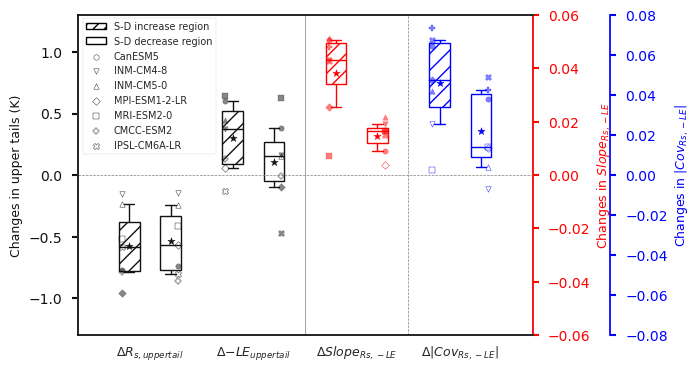

In [64]:
fig= plt.figure(figsize=(7, 4))
#fig,axs = plt.subplots(figsize=(4, 2),ncols=4,nrows=1)
ax1 = plt.axes([0.1, 0.1, 0.65, 0.8])
ax2 = ax1.twinx()
ax3 = ax1.twinx()
all_data = []
for box_temp,pos,c_l in zip(var_all,range(4),['k','k','red','blue']):
    if pos==0:
        ax=ax1
    if pos==1:
        ax=ax1
    elif pos==2:
        ax=ax2
    elif pos==3:
        ax=ax3
    box_temp1 = np.array(box_temp[0])    
    #bp = ax.boxplot(box_temp1,widths=0.2, positions=[pos+1-0.2],whis = [5, 95],flierprops = dict(marker='o', markerfacecolor=(0, 0, 0, 0),  markeredgecolor=c_l,linewidth=3),boxprops = dict(linestyle='-', linewidth=3),medianprops = dict( linewidth=3)   ,whiskerprops = dict( linewidth=3)   ,capprops = dict( linewidth=3) )
    bp = ax.boxplot(box_temp1,widths=0.2, positions=[pos+1-0.2],whis = [5, 95],flierprops = dict(marker='o', markerfacecolor=(0, 0, 0, 0),  markeredgecolor=c_l,linewidth=3), patch_artist=True ,showfliers=False,showmeans=False)
    
    for element in ['whiskers','caps','medians','boxes']:
        for patch in bp[element] :
            plt.setp(patch, color=c_l)
    sig_up = sig_all1[pos][0]
    sig_bottom = sig_all2[pos][0]
    box_temp1_sig = []
    box_temp1_nonsig = []
    for jjj in np.arange(7):
        if (box_temp1[jjj]<sig_up[jjj])&(box_temp1[jjj]>sig_bottom[jjj]):
            box_temp1_sig.append(np.nan)
            box_temp1_nonsig.append(box_temp1[jjj] )
        else:
            box_temp1_nonsig.append(np.nan)
            box_temp1_sig.append(box_temp1[jjj] )  
    for i_sig, i_mark,i_label,i_s in zip(box_temp1_sig,["o","v","^","D","s","P","X"],['CanESM5','INM-CM4-8','INM-CM5-0','MPI-ESM1-2-LR','MRI-ESM2-0','CMCC-ESM2','IPSL-CM6A-LR'],[15,15,15,15,15,20,20]) :
        ax.scatter([pos+1-0.27],[i_sig], marker=i_mark, color=c_l, s=i_s ,alpha=0.5)         
    for i_sig, i_mark,i_label,i_s  in zip(box_temp1_nonsig,["o","v","^","D","s","P","X"],['CanESM5','INM-CM4-8','INM-CM5-0','MPI-ESM1-2-LR','MRI-ESM2-0','CMCC-ESM2','IPSL-CM6A-LR'],[15,15,15,15,15,20,20]) :
        model_scatter=ax.scatter([pos+1-0.27],[i_sig],facecolor=(0, 0, 0, 0), marker=i_mark, edgecolor=c_l, s=i_s )      
    ax.scatter([pos+1-0.2],np.nanmean(box_temp1),c=c_l,s=30,marker='*')  

    for box in bp['boxes']:
        # change outline color
        #box.set(color='red', linewidth=2)
        # change fill color
        #box.set(facecolor = 'green' )
        # change hatch
        box.set_facecolor((0, 0, 0, 0))
        box.set(hatch = '//') 


    box_temp1 = np.array(box_temp[1])
    #bp2 = ax.boxplot(box_temp1,widths=0.2, positions=[pos+1+0.2],whis = [5, 95],flierprops = dict(marker='o', markerfacecolor=(0, 0, 0, 0),  markeredgecolor=c_l),boxprops = dict(linestyle='--', linewidth=1),medianprops = dict( linestyle='--', linewidth=1)   ,whiskerprops = dict( linestyle='--', linewidth=1)   ,capprops = dict( linestyle='--', linewidth=1) )
    bp = ax.boxplot(box_temp1,widths=0.2, positions=[pos+1+0.2],whis = [5, 95],flierprops = dict(marker='o', markerfacecolor=(0, 0, 0, 0),  markeredgecolor=c_l),showfliers=False,showmeans=False, patch_artist=True)
    #ax.scatter(np.array(7*[pos+1+0.2]),box_temp1,facecolor=(0, 0, 0, 0),  edgecolor=c_l, s=10)
    for element in ['whiskers','caps','medians','boxes']:
        for patch in bp[element] :
            plt.setp(patch, color=c_l)
    sig_up = sig_all1[pos][1]
    sig_bottom = sig_all2[pos][1]
    box_temp1_sig = []
    box_temp1_nonsig = []
    for jjj in np.arange(7):
        if (box_temp1[jjj]<sig_up[jjj])&(box_temp1[jjj]>sig_bottom[jjj]):
            box_temp1_sig.append(np.nan)
            box_temp1_nonsig.append(box_temp1[jjj] )
        else:
            box_temp1_nonsig.append(np.nan)
            box_temp1_sig.append(box_temp1[jjj] )  
    for i_sig, i_mark,i_label,i_s in zip(box_temp1_sig,["o","v","^","D","s","P","X"],['CanESM5','INM-CM4-8','INM-CM5-0','MPI-ESM1-2-LR','MRI-ESM2-0','CMCC-ESM2','IPSL-CM6A-LR'],[15,15,15,15,15,20,20]) :
        ax.scatter([pos+1+0.27],[i_sig], marker=i_mark, color=c_l, s=i_s ,alpha=0.5)
    if pos==0:
        s_legend= []         
        for i_sig, i_mark,i_label,i_s  in zip(box_temp1_nonsig,["o","v","^","D","s","P","X"],['CanESM5','INM-CM4-8','INM-CM5-0','MPI-ESM1-2-LR','MRI-ESM2-0','CMCC-ESM2','IPSL-CM6A-LR'],[15,15,15,15,15,20,20]) :
            s_legend.append(ax.scatter([pos+1+0.27],[i_sig],facecolor=(0, 0, 0, 0), marker=i_mark, edgecolor=c_l, s=i_s) )
    else:
        for i_sig, i_mark,i_label,i_s  in zip(box_temp1_nonsig,["o","v","^","D","s","P","X"],['CanESM5','INM-CM4-8','INM-CM5-0','MPI-ESM1-2-LR','MRI-ESM2-0','CMCC-ESM2','IPSL-CM6A-LR'],[15,15,15,15,15,20,20]) :
            ax.scatter([pos+1+0.27],[i_sig],facecolor=(0, 0, 0, 0), marker=i_mark, edgecolor=c_l, s=i_s)   
    ax.scatter([pos+1+0.2],np.nanmean(box_temp1),c=c_l,s=30,marker='*')   
    for box in bp['boxes']:
        # change outline color
        #box.set(color='red', linewidth=2)
        # change fill color
        #box.set(facecolor = 'green' )
        # change hatch
        box.set_facecolor((0, 0, 0, 0))
        #box.set(hatch = '/')    

    #plt.text(pos+1,16,'%.2f'%np.nanmean(box_temp1),fontsize=9,c='r',ha='left')
ax.axhline(y = 0, color = 'grey', linestyle = '--',linewidth=0.5)
# ax.axvline(x = 1.5, color = 'grey', linestyle = '--')
ax.axvline(x = 2.5 ,color = 'grey', linestyle = '-',linewidth=0.5)
ax.axvline(x = 3.5, color = 'grey', linestyle = '--',linewidth=0.5)
ax1.set_ylabel('Changes in upper tails (K)',fontsize=9) 
# ax11.set_ylabel('Changes in $-LE_{upper tail}$ (K)',fontsize=9) 
ax2.set_ylabel('Changes in $Slope_{Rs,-LE}$',fontsize=9) 
ax3.set_ylabel('Changes in |$Cov_{Rs,-LE}$|',fontsize=9) 

ax1.yaxis.label.set_color('k')
ax2.yaxis.label.set_color('red')
ax3.yaxis.label.set_color('blue')
tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='y', colors='k', **tkw)
ax2.tick_params(axis='y', colors='red', **tkw)
ax3.tick_params(axis='y', colors='blue', **tkw)


ax1.grid(b=False)
ax2.grid(b=False)
ax1.set_ylim(-1.3,1.3)
ax2.set_ylim(-0.06,0.06)
ax3.set_ylim(-0.08,0.08)
# ax1.set_yticks(np.arange(-0.06,0.08,0.02))
ax1.set_xticks([1,2,3,4])
ax1.set_xticklabels(['$\Delta$$R_{s,upper tail}$','$\Delta$$-LE_{upper tail}$','$\Delta$$Slope_{Rs,-LE}$','$\Delta$|$Cov_{Rs,-LE}$|'],fontsize=9)
ax1.legend(fontsize=9,loc='lower right')



ax3.spines['left'].set_color('k')        # setting up Y-axis tick color to red
ax3.spines['top'].set_color('k') 
ax3.spines['bottom'].set_color('k') 
 
ax2.spines['right'].set_color('red')    
ax3.spines['right'].set_color('blue') 

ax3.spines.right.set_position(("axes", 1.17))

ax1.grid(False)
ax2.grid(False)
ax3.grid(False)


all_legend = []
all_legend.append(bp1["boxes"][0])
all_legend.append(bp2["boxes"][0])
all_legend.extend(s_legend)
all_label = ['S-D increase region', 'S-D decrease region']
all_label.extend(['CanESM5','INM-CM4-8','INM-CM5-0','MPI-ESM1-2-LR','MRI-ESM2-0','CMCC-ESM2','IPSL-CM6A-LR'])
# ax2.legend([bp1["boxes"][0], bp2["boxes"][0]], ['S-D increase region', 'S-D decrease region'])
# ax3.legend(s_legend,['CanESM5','INM-CM4-8','INM-CM5-0','MPI-ESM1-2-LR','MRI-ESM2-0','CMCC-ESM2','IPSL-CM6A-LR'],loc='lower right')
legend = ax3.legend(all_legend,all_label,loc='lower right',fontsize=7,bbox_to_anchor=(0.315,0.55),frameon='True')

# plt.subplots_adjust(wspace=0.6,bottom=0.25,left=0.1,right=0.9)
fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_99th_connect6/cmip6_changes_heating_slope1_new.jpg', dpi=300)

# plt.subplots_adjust(wspace=0.6,bottom=0.25,left=0.1,right=0.9)
fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_99th_connect6/cmip6_changes_heating_slope1_new.jpg', dpi=300)

# Fig 5d

In [65]:
sig_all1 = [[sig_delta_adv_po1,sig_delta_adv_ne1],[sig_delta_strd_po1,sig_delta_strd_ne1],[np.array(sig_delta_ADVslope_po1),np.array(sig_delta_ADVslope_ne1)],[np.array(sig_delta_ADVcorr_po1),np.array(sig_delta_ADVcorr_ne1)]]
sig_all2 = [[sig_delta_adv_po2,sig_delta_adv_ne2],[sig_delta_strd_po2,sig_delta_strd_ne2],[np.array(sig_delta_ADVslope_po2),np.array(sig_delta_ADVslope_ne2)],[np.array(sig_delta_ADVcorr_po2),np.array(sig_delta_ADVcorr_ne2)]]
var_all = [[delta_adv_po,delta_adv_ne],[np.array(delta_strd_po),delta_strd_ne],[np.array(delta_ADVslope_po),np.array(delta_ADVslope_ne)],[np.array(delta_ADVcorr_po),np.array(delta_ADVcorr_ne)]]

/tmp/ipykernel_1333718/2790437768.py:99: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=False)
/tmp/ipykernel_1333718/2790437768.py:100: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax2.grid(b=False)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_1333718/2790437768.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


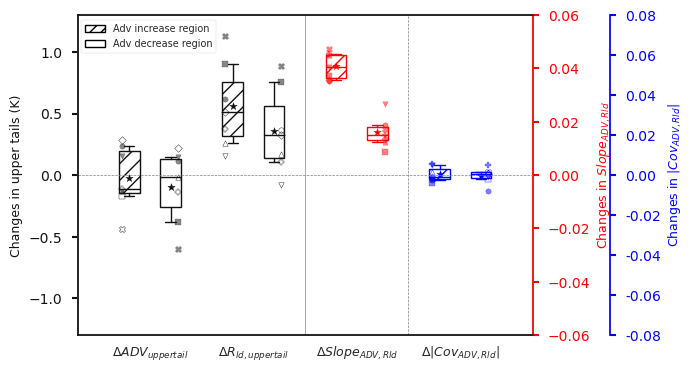

In [70]:
from matplotlib.ticker import FormatStrFormatter
fig= plt.figure(figsize=(7, 4))
#fig,axs = plt.subplots(figsize=(4, 2),ncols=4,nrows=1)
ax1 = plt.axes([0.1, 0.1, 0.65, 0.8])
ax2 = ax1.twinx()
ax3 = ax1.twinx()
all_data = []
for box_temp,pos,c_l in zip(var_all,range(4),['k','k','red','blue']):
    if pos==0:
        ax=ax1
    if pos==1:
        ax=ax1
    elif pos==2:
        ax=ax2
    elif pos==3:
        ax=ax3
    box_temp1 = np.array(box_temp[0])    
    #bp = ax.boxplot(box_temp1,widths=0.2, positions=[pos+1-0.2],whis = [5, 95],flierprops = dict(marker='o', markerfacecolor=(0, 0, 0, 0),  markeredgecolor=c_l,linewidth=3),boxprops = dict(linestyle='-', linewidth=3),medianprops = dict( linewidth=3)   ,whiskerprops = dict( linewidth=3)   ,capprops = dict( linewidth=3) )
    bp = ax.boxplot(box_temp1,widths=0.2, positions=[pos+1-0.2],whis = [5, 95],flierprops = dict(marker='o', markerfacecolor=(0, 0, 0, 0),  markeredgecolor=c_l,linewidth=3), patch_artist=True,showfliers=False,showmeans=False )
    for element in ['whiskers','caps','medians','boxes']:
        for patch in bp[element] :
            plt.setp(patch, color=c_l)
    sig_up = sig_all1[pos][0]
    sig_bottom = sig_all2[pos][0]
    box_temp1_sig = []
    box_temp1_nonsig = []
    for jjj in np.arange(7):
        if (box_temp1[jjj]<sig_up[jjj])&(box_temp1[jjj]>sig_bottom[jjj]):
            box_temp1_sig.append(np.nan)
            box_temp1_nonsig.append(box_temp1[jjj] )
        else:
            box_temp1_nonsig.append(np.nan)
            box_temp1_sig.append(box_temp1[jjj] )  
    for i_sig, i_mark,i_label,i_s in zip(box_temp1_sig,["o","v","^","D","s","P","X"],['CanESM5','INM-CM4-8','INM-CM5-0','MPI-ESM1-2-LR','MRI-ESM2-0','CMCC-ESM2','IPSL-CM6A-LR'],[15,15,15,15,15,20,20]) :
        ax.scatter([pos+1-0.27],[i_sig], marker=i_mark, color=c_l, s=i_s ,alpha=0.5)         
    for i_sig, i_mark,i_label,i_s  in zip(box_temp1_nonsig,["o","v","^","D","s","P","X"],['CanESM5','INM-CM4-8','INM-CM5-0','MPI-ESM1-2-LR','MRI-ESM2-0','CMCC-ESM2','IPSL-CM6A-LR'],[15,15,15,15,15,20,20]) :
        model_scatter=ax.scatter([pos+1-0.27],[i_sig],facecolor=(0, 0, 0, 0), marker=i_mark, edgecolor=c_l, s=i_s )      
    ax.scatter([pos+1-0.2],np.nanmean(box_temp1),c=c_l,s=30,marker='*')  


    for box in bp['boxes']:
        # change outline color
        #box.set(color='red', linewidth=2)
        # change fill color
        #box.set(facecolor = 'green' )
        # change hatch
        box.set_facecolor((0, 0, 0, 0))
        box.set(hatch = '//') 
    box_temp1 = np.array(box_temp[1])
    #bp2 = ax.boxplot(box_temp1,widths=0.2, positions=[pos+1+0.2],whis = [5, 95],flierprops = dict(marker='o', markerfacecolor=(0, 0, 0, 0),  markeredgecolor=c_l),boxprops = dict(linestyle='--', linewidth=1),medianprops = dict( linestyle='--', linewidth=1)   ,whiskerprops = dict( linestyle='--', linewidth=1)   ,capprops = dict( linestyle='--', linewidth=1) )
    bp = ax.boxplot(box_temp1,widths=0.2, positions=[pos+1+0.2],whis = [5, 95],flierprops = dict(marker='o', markerfacecolor=(0, 0, 0, 0),  markeredgecolor=c_l),showfliers=False,showmeans=False, patch_artist=True)
    for element in ['whiskers','caps','medians','boxes']:
        for patch in bp[element] :
            plt.setp(patch, color=c_l)
    sig_up = sig_all1[pos][1]
    sig_bottom = sig_all2[pos][1]
    box_temp1_sig = []
    box_temp1_nonsig = []
    for jjj in np.arange(7):
        if (box_temp1[jjj]<sig_up[jjj])&(box_temp1[jjj]>sig_bottom[jjj]):
            box_temp1_sig.append(np.nan)
            box_temp1_nonsig.append(box_temp1[jjj] )
        else:
            box_temp1_nonsig.append(np.nan)
            box_temp1_sig.append(box_temp1[jjj] )  
    for i_sig, i_mark,i_label,i_s in zip(box_temp1_sig,["o","v","^","D","s","P","X"],['CanESM5','INM-CM4-8','INM-CM5-0','MPI-ESM1-2-LR','MRI-ESM2-0','CMCC-ESM2','IPSL-CM6A-LR'],[15,15,15,15,15,20,20]) :
        ax.scatter([pos+1+0.27],[i_sig], marker=i_mark, color=c_l, s=i_s ,alpha=0.5)         
    for i_sig, i_mark,i_label,i_s  in zip(box_temp1_nonsig,["o","v","^","D","s","P","X"],['CanESM5','INM-CM4-8','INM-CM5-0','MPI-ESM1-2-LR','MRI-ESM2-0','CMCC-ESM2','IPSL-CM6A-LR'],[15,15,15,15,15,20,20]) :
        model_scatter=ax.scatter([pos+1+0.27],[i_sig],facecolor=(0, 0, 0, 0), marker=i_mark, edgecolor=c_l, s=i_s )      
    ax.scatter([pos+1+0.2],np.nanmean(box_temp1),c=c_l,s=30,marker='*')  

    for box in bp['boxes']:
        # change outline color
        #box.set(color='red', linewidth=2)
        # change fill color
        #box.set(facecolor = 'green' )
        # change hatch
        box.set_facecolor((0, 0, 0, 0))
        #box.set(hatch = '/')     
  

    #plt.text(pos+1,16,'%.2f'%np.nanmean(box_temp1),fontsize=9,c='r',ha='left')
ax.axhline(y = 0, color = 'grey', linestyle = '--',linewidth=0.5)
ax.axvline(x = 2.5 ,color = 'grey', linestyle = '-',linewidth=0.5)
ax.axvline(x = 3.5, color = 'grey', linestyle = '--',linewidth=0.5)
ax1.set_ylabel('Changes in upper tails (K)',fontsize=9) 
ax2.set_ylabel('Changes in $Slope_{ADV,Rld}$',fontsize=9) 
ax3.set_ylabel('Changes in |$Cov_{ADV,Rld}$|',fontsize=9) 

ax1.yaxis.label.set_color('k')
ax2.yaxis.label.set_color('red')
ax3.yaxis.label.set_color('blue')
tkw = dict(size=4, width=1.5)
ax1.tick_params(axis='y', colors='k', **tkw)
ax2.tick_params(axis='y', colors='red', **tkw)
ax3.tick_params(axis='y', colors='blue', **tkw)


ax1.grid(b=False)
ax2.grid(b=False)
ax1.set_ylim(-1.3,1.3)
ax2.set_ylim(-0.06,0.06)
ax3.set_ylim(-0.08,0.08)

ax1.set_xticks([1,2,3,4])
ax1.set_xticklabels(['$\Delta$$ADV_{uppertail}$','$\Delta$$R_{ld,uppertail}$','$\Delta$$Slope_{ADV,Rld}$','$\Delta$|$Cov_{ADV,Rld}$|'],fontsize=9)
ax1.legend(fontsize=9,loc='lower right')



ax3.spines['left'].set_color('k')        # setting up Y-axis tick color to red
ax3.spines['top'].set_color('k') 
ax3.spines['bottom'].set_color('k') 
 
ax2.spines['right'].set_color('red')    
ax3.spines['right'].set_color('blue') 


ax3.spines.right.set_position(("axes", 1.17))

ax1.grid(False)
ax2.grid(False)
ax3.grid(False)

fig.tight_layout()
# ax3.set_yticks(np.arange(-0.08,0.03,0.01))
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
#ax3.legend([bp1["boxes"][0], bp2["boxes"][0]], ['ADV increase region', 'ADV decrease region'],loc='lower right')
# plt.subplots_adjust(wspace=0.6,bottom=0.25,left=0.1,right=0.9)
legend = ax3.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Adv increase region', 'Adv decrease region'],fontsize=7,bbox_to_anchor=(0.315,1),frameon='True')

fig.savefig(r'/Net/Groups/BGI/scratch/yt/figure/Heat_wave_3D_99th_connect6/cmip6_changes_heating_slope2_new.jpg', dpi=300)